## **DISCLAIMER Y SUPUESTOS DEL MODELO**

### **🚫 Limitaciones de los Datos:**
- **📊 Datos completamente artificiales**: Generados sintéticamente, no reflejan una organización real
- **🎓 Propósito académico/demostrativo**: Para mostrar capacidades técnicas del pipeline
- **❌ No usar para decisiones reales**: Los resultados no deben aplicarse en entornos empresariales sin validación

### **🏗️ Supuestos de Estructura de Datos:**
- **📋 Incompletitud de datos históricos**: El dataset no es un registro completo de cada combinación (Proyecto, Área, Trimestre) a lo largo de los cuatro años. Representa un muestreo disperso y no uniforme de datos operativos con recolección irregular
- **🔍 Desajuste de granularidad**: Los 1500 registros simulan un entorno real donde los datos se recopilan con granularidad más fina que la trimestral (mensuales, semanales o por eventos), posteriormente agregados para análisis trimestral
- **🔄 Ciclos de vida del proyecto**: El modelo usa el estado más reciente conocido de cada combinación proyecto-área para proyecciones futuras, aplicando `drop_duplicates(keep='last')` como enfoque práctico
- **📐 Lógica de pronóstico estructurado**: El pipeline genera una cuadrícula uniforme de puntos futuros (28 proyectos × 4 trimestres = 112 registros) basada en entidades históricas únicas

### **📊 Supuestos de Generación de Datos:**
- **🎲 Distribución Poisson para dotación**: Modela eventos discretos (número de empleados) con tasa promedio fija, apropiada para conteos de personal
- **📈 Distribución Normal para costos y horas**: Refleja variables continuas que tienden a concentrarse alrededor de un promedio con variación simétrica
- **📏 Distribución Uniforme para carga laboral**: Asume equiprobabilidad en el rango de capacidad operativa (subcarga a sobrecarga)
- **🎯 Distribución Binomial para ingresos/ceses**: Modela decisiones binarias independientes (contratar/no contratar, cesar/no cesar) para cada empleado

### **🤖 Supuestos del Modelo Predictivo:**
- **💰 Factores de costo considerados**: 3.2x para ingresos (costo trimestral + gastos de contratación), 1.5x para ceses (liquidación + beneficios sociales)
- **📈 Crecimiento constante**: 5% trimestral en variables operacionales
- **📊 Patrones históricos**: Asume que tendencias pasadas se mantienen en el futuro
- **🔒 Variables exógenas constantes**: Eventos externos, crisis económicas y cambios organizacionales se consideran constantes y no se incluyen en el modelo

# 📊 Paso 1: Generación de Datos Sintéticos

---

## 🎯 **¿Qué hace este paso?**

Genera un **dataset sintético** que simula datos reales de ingresos y ceses de personal para entrenar nuestro modelo de RNA. Este dataset controlado nos permite experimentar sin usar datos sensibles de la empresa.

## 🔧 **Proceso de Generación**

### **Datos que se crean:**
- **📅 Variables temporales**: Años (2021-2024) y trimestres (Q1-Q4)
- **🏢 Variables organizacionales**: Áreas de trabajo y proyectos
- **⚙️ Variables operacionales**: Dotación actual, horas extra, carga laboral
- **👥 Variables objetivo**: Ingresos y ceses por trimestre (nuestros targets)
- **💰 Variables financieras**: Costos y presupuestos relacionados

### **Características técnicas:**
- ✅ **Reproducible**: Semilla fija (seed=42) para resultados consistentes
- ✅ **Realista**: Distribuciones estadísticas que simulan comportamiento real
- ✅ **Escalable**: Fácil cambiar el número de filas y parámetros
- ✅ **Legible**: Código modularizado y bien documentado

## 📋 **Dataset Resultante**

| Filas | Columnas | Archivo de Salida |
|-------|----------|-------------------|
| 200 | 12 | `dataset_contrataciones.csv` |

**Variables principales:**
- `Ingresos_Q`: Número de ingresos por trimestre 🎯
- `Ceses_Q`: Número de ceses por trimestre 🎯  
- `Dotación_Actual`: Personal actual del área
- `Carga_Laboral_Relativa`: Índice de carga de trabajo

---


In [36]:
# =====================================================
# Generación de Datos Sintéticos
# =====================================================

import pandas as pd
import numpy as np
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# =====================================================
# 1. CONFIGURACIÓN Y CONSTANTES
# =====================================================

class DataConfig:
    """Configuración centralizada para la generación de datos sintéticos"""

    # Configuración de reproducibilidad
    RANDOM_SEED = 42

    # Parámetros temporales
    AÑOS = [2021, 2022, 2023, 2024]
    TRIMESTRES = ['Q1', 'Q2', 'Q3', 'Q4']

    # Configuración organizacional
    ÁREAS = ['Ventas', 'TI', 'Marketing', 'Logistica', 'Operaciones', 'RRHH', 'Finanzas']
    PROYECTOS = ['Proyecto A', 'Proyecto B', 'Proyecto C', 'Proyecto D']

    # Parámetros de generación
    NUM_ROWS = 200

    # Parámetros estadísticos para variables numéricas
    DOTACION_LAMBDA = 25
    HORAS_EXTRA_MEDIA = 5
    HORAS_EXTRA_STD = 2
    CARGA_LABORAL_MIN = 0.8
    CARGA_LABORAL_MAX = 1.2

    # Parámetros de ingresos y ceses
    PROB_INGRESOS = 0.05
    PROB_CESES = 0.03

    # Parámetros financieros
    COSTO_EMPLEADO_MEDIA = 2500
    COSTO_EMPLEADO_STD = 400
    COSTO_EMPLEADO_MIN = 1000
    VARIACION_PRESUPUESTO_MIN = 0.9
    VARIACION_PRESUPUESTO_MAX = 1.1


# =====================================================
# 2. FUNCIONES DE GENERACIÓN DE DATOS
# =====================================================

def configurar_semilla_aleatoria(seed: int = DataConfig.RANDOM_SEED) -> None:
    """
    Configura la semilla aleatoria para reproducibilidad

    Args:
        seed (int): Valor de la semilla aleatoria
    """
    np.random.seed(seed)
    print(f"Semilla aleatoria configurada: {seed}")


def generar_variables_categoricas(num_rows: int) -> Dict[str, np.ndarray]:
    """
    Genera las variables categóricas del dataset

    Args:
        num_rows (int): Número de filas a generar

    Returns:
        Dict[str, np.ndarray]: Diccionario con las variables categóricas
    """
    return {
        'Año': np.random.choice(DataConfig.AÑOS, size=num_rows),
        'Trimestre': np.random.choice(DataConfig.TRIMESTRES, size=num_rows),
        'Área': np.random.choice(DataConfig.ÁREAS, size=num_rows),
        'Proyecto': np.random.choice(DataConfig.PROYECTOS, size=num_rows)
    }


def generar_variables_operacionales(num_rows: int) -> Dict[str, np.ndarray]:
    """
    Genera las variables operacionales del dataset

    Args:
        num_rows (int): Número de filas a generar

    Returns:
        Dict[str, np.ndarray]: Diccionario con las variables operacionales
    """
    return {
        'Dotación_Actual': np.random.poisson(lam=DataConfig.DOTACION_LAMBDA, size=num_rows),
        'Horas_Extra_Prom_Q': np.random.normal(
            loc=DataConfig.HORAS_EXTRA_MEDIA,
            scale=DataConfig.HORAS_EXTRA_STD,
            size=num_rows
        ).clip(min=0),
        'Carga_Laboral_Relativa': np.random.uniform(
            DataConfig.CARGA_LABORAL_MIN,
            DataConfig.CARGA_LABORAL_MAX,
            size=num_rows
        )
    }


def calcular_ingresos_y_ceses(dotacion_actual: np.ndarray) -> Dict[str, np.ndarray]:
    """
    Calcula los ingresos y ceses basados en la dotación actual

    Args:
        dotacion_actual (np.ndarray): Array con la dotación actual

    Returns:
        Dict[str, np.ndarray]: Diccionario con ingresos y ceses
    """
    ingresos = np.random.binomial(
        n=(dotacion_actual + 5).astype(int),
        p=DataConfig.PROB_INGRESOS
    )

    ceses = np.random.binomial(
        n=dotacion_actual.astype(int),
        p=DataConfig.PROB_CESES
    )

    return {
        'Ingresos_Q': ingresos,
        'Ceses_Q': ceses
    }


def calcular_variables_financieras(ingresos: np.ndarray, ceses: np.ndarray, num_rows: int) -> Dict[str, np.ndarray]:
    """
    Calcula las variables financieras del dataset con factores realistas de costos de RRHH

    Args:
        ingresos (np.ndarray): Array con los ingresos por trimestre
        ceses (np.ndarray): Array con los ceses por trimestre
        num_rows (int): Número de filas del dataset

    Returns:
        Dict[str, np.ndarray]: Diccionario con las variables financieras

    Supuestos del modelo:
        - Factor Ingresos (3.2): 3 meses de salario trimestral + 20% costos de reclutamiento/onboarding
        - Factor Ceses (1.5): 1 mes liquidación base + 0.5 mes beneficios sociales/vacaciones
    """
    # Factores de costo
    FACTOR_INGRESOS = 3.2  # Costo trimestral completo + gastos de contratación y onboarding
    FACTOR_CESES = 1.5     # Liquidación + beneficios sociales

    # Costo promedio por empleado
    costo_empleado = np.random.normal(
        loc=DataConfig.COSTO_EMPLEADO_MEDIA,
        scale=DataConfig.COSTO_EMPLEADO_STD,
        size=num_rows
    ).clip(min=DataConfig.COSTO_EMPLEADO_MIN)

    # Variación aleatoria del presupuesto (±10%)
    variacion_presupuesto = np.random.uniform(
        DataConfig.VARIACION_PRESUPUESTO_MIN,
        DataConfig.VARIACION_PRESUPUESTO_MAX,
        size=num_rows
    )

    return {
        'Costo_Promedio_Empleado': costo_empleado,
        'Presupuesto_Ingresos': ingresos * costo_empleado * variacion_presupuesto * FACTOR_INGRESOS,
        'Presupuesto_Ceses': ceses * costo_empleado * variacion_presupuesto * FACTOR_CESES
    }


def aplicar_formato_y_redondeo(df: pd.DataFrame) -> pd.DataFrame:
    """
    Aplica formato y redondeo a las columnas numéricas

    Args:
        df (pd.DataFrame): DataFrame original

    Returns:
        pd.DataFrame: DataFrame con formato aplicado
    """
    df_formatted = df.copy()

    # Redondeo de columnas específicas
    columnas_redondeo = {
        'Horas_Extra_Prom_Q': 1,
        'Presupuesto_Ingresos': 2,
        'Presupuesto_Ceses': 2
    }

    for columna, decimales in columnas_redondeo.items():
        if columna in df_formatted.columns:
            df_formatted[columna] = df_formatted[columna].round(decimales)

    return df_formatted


# =====================================================
# 3. FUNCIÓN PRINCIPAL DE GENERACIÓN
# =====================================================

def generar_dataset_sintetico(
    num_rows: int = DataConfig.NUM_ROWS,
    guardar_csv: bool = True,
    nombre_archivo: str = "dataset_contrataciones.csv"
) -> pd.DataFrame:
    """
    Función principal que genera el dataset sintético completo

    Args:
        num_rows (int): Número de filas a generar
        guardar_csv (bool): Si guardar el dataset en CSV
        nombre_archivo (str): Nombre del archivo CSV

    Returns:
        pd.DataFrame: Dataset sintético generado
    """
    print("Iniciando generación de dataset sintético...")

    # Configurar reproducibilidad
    configurar_semilla_aleatoria()

    # Generar variables categóricas
    print("Generando variables categóricas...")
    variables_categoricas = generar_variables_categoricas(num_rows)

    # Generar variables operacionales
    print("Generando variables operacionales...")
    variables_operacionales = generar_variables_operacionales(num_rows)

    # Combinar datos base
    datos_base = {**variables_categoricas, **variables_operacionales}
    df = pd.DataFrame(datos_base)

    # Calcular ingresos y ceses
    print("Calculando ingresos y ceses...")
    ingresos_ceses = calcular_ingresos_y_ceses(df['Dotación_Actual'])
    for key, value in ingresos_ceses.items():
        df[key] = value

    # Calcular variables financieras
    print("Calculando variables financieras...")
    variables_financieras = calcular_variables_financieras(
        df['Ingresos_Q'],
        df['Ceses_Q'],
        num_rows
    )
    for key, value in variables_financieras.items():
        df[key] = value

    # Aplicar formato y redondeo
    print("Aplicando formato final...")
    df = aplicar_formato_y_redondeo(df)

    # Guardar archivo si se solicita
    if guardar_csv:
        df.to_csv(nombre_archivo, index=False)
        print(f"Dataset guardado como: {nombre_archivo}")

    return df


def mostrar_resumen_dataset(df: pd.DataFrame) -> None:
    """
    Muestra un resumen del dataset generado

    Args:
        df (pd.DataFrame): Dataset a resumir
    """
    print("\n" + "="*50)
    print("RESUMEN DEL DATASET GENERADO")
    print("="*50)

    print(f"Total de filas: {len(df):,}")
    print(f"Total de columnas: {len(df.columns)}")

    print(f"\n Áreas únicas: {df['Área'].nunique()}")
    print(f"Años cubiertos: {[int(year) for year in sorted(df['Año'].unique())]}")
    print(f"Trimestres: {sorted(df['Trimestre'].unique())}")

    print(f"\n Estadísticas de personal:")
    print(f"  • Dotación promedio: {df['Dotación_Actual'].mean():.1f}")
    print(f"  • Ingresos promedio/Q: {df['Ingresos_Q'].mean():.1f}")
    print(f"  • Ceses promedio/Q: {df['Ceses_Q'].mean():.1f}")

    print(f"\n Estadísticas financieras:")
    print(f"  • Costo promedio/empleado: S/{df['Costo_Promedio_Empleado'].mean():,.0f}")
    print(f"  • Presupuesto ingresos promedio: S/{df['Presupuesto_Ingresos'].mean():,.0f}")
    print(f"  • Presupuesto ceses promedio: S/{df['Presupuesto_Ceses'].mean():,.0f}")

    print(f"\n Primeras 5 filas:")
    display(df.head())


# =====================================================
# 4. EJECUCIÓN PRINCIPAL
# =====================================================

if __name__ == "__main__":
    # Generar dataset
    dataset = generar_dataset_sintetico()

    # Mostrar resumen
    mostrar_resumen_dataset(dataset)






Iniciando generación de dataset sintético...
Semilla aleatoria configurada: 42
Generando variables categóricas...
Generando variables operacionales...
Calculando ingresos y ceses...
Calculando variables financieras...
Aplicando formato final...
Dataset guardado como: dataset_contrataciones.csv

RESUMEN DEL DATASET GENERADO
Total de filas: 200
Total de columnas: 12

 Áreas únicas: 7
Años cubiertos: [2021, 2022, 2023, 2024]
Trimestres: ['Q1', 'Q2', 'Q3', 'Q4']

 Estadísticas de personal:
  • Dotación promedio: 24.1
  • Ingresos promedio/Q: 1.4
  • Ceses promedio/Q: 0.8

 Estadísticas financieras:
  • Costo promedio/empleado: S/2,547
  • Presupuesto ingresos promedio: S/11,703
  • Presupuesto ceses promedio: S/2,960

 Primeras 5 filas:


,Año,Trimestre,Área,Proyecto,Dotación_Actual,Horas_Extra_Prom_Q,Carga_Laboral_Relativa,Ingresos_Q,Ceses_Q,Costo_Promedio_Empleado,Presupuesto_Ingresos,Presupuesto_Ceses
0,2023,Q3,Logistica,Proyecto A,28,4.3,0.841004,2,3,2796.838149,19189.05,13492.30
1,2024,Q4,Marketing,Proyecto C,17,4.9,1.174891,1,0,2619.717032,8756.67,0.00
2,2021,Q3,Ventas,Proyecto B,15,5.6,1.075154,2,1,3020.696516,17660.85,4139.26
3,2023,Q1,Logistica,Proyecto D,24,1.6,0.827135,0,0,3124.604479,0.00,0.00
4,2023,Q4,RRHH,Proyecto B,23,2.3,0.920385,4,0,2512.801660,32443.93,0.00


# ⚙️ Paso 2: Preprocesamiento de Datos y Entrenamiento RNA

---

## 🎯 **¿Qué hace este paso?**

Transforma los datos sintéticos del Paso 1 en formato optimizado para entrenamiento y desarrolla **dos modelos independientes** de RNA para predecir ingresos y ceses de personal.

## 🔄 **Proceso de Entrenamiento (2.1 - 2.9)**

### **🔧 Preprocesamiento aplicado:**
- **Variables categóricas**: One-Hot Encoding (Trimestre, Área, Proyecto)
- **Variables numéricas**: StandardScaler para normalización
- **División de datos**: 80% entrenamiento, 20% prueba

### **🧠 Arquitecturas disponibles:**

| Opción | Nombre | Capas | Tipo |
|--------|--------|--------|------|
| **1** | Ligero | 64 → 32 | RNA Clásica |
| **2** | Estándar | 128 → 64 → 32 | Deep Learning |
| **3** | Profundo | 256 → 128 → 64 → 32 | Deep Learning |
| **4** | Mínimo | 32 → 16 | RNA Clásica |

### **⚙️ Configuración técnica:**
- **Optimizador**: Adam (lr=0.001)
- **Regularización**: BatchNormalization + Dropout (20%)
- **Callbacks**: EarlyStopping, ReduceLROnPlateau
- **Épocas**: Máximo 250 con parada temprana

---

## 📊 **Modelos y Evaluación**

### **🎯 Dos modelos especializados:**
- **Modelo Ingresos**: Predice contrataciones por trimestre
- **Modelo Ceses**: Predice renuncias por trimestre

### **📈 Métricas calculadas:**
- **MAE**: Error promedio en número de personas
- **RMSE**: Penaliza errores grandes  
- **R²**: Porcentaje de varianza explicada

### **💾 Salidas generadas:**
- Modelos entrenados guardados automáticamente
- Scalers y encoders para futuras predicciones
- Métricas de evaluación detalladas

---


In [37]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import os

# =====================================================
# CONFIGURACIÓN
# =====================================================
class MLConfig:
    DATASET_FILE = "dataset_contrataciones.csv"
    TARGET_INGRESOS = 'Ingresos_Q'
    TARGET_CESES = 'Ceses_Q'
    CATEGORICAL_COLS = ['Trimestre', 'Área', 'Proyecto']
    TEST_SIZE = 0.2
    RANDOM_STATE = 42
    EPOCHS = 250
    BATCH_SIZE = 16
    LEARNING_RATE = 0.001

# =====================================================
# VARIABLES GLOBALES
# =====================================================
global_vars = {
    'df': None,
    'X_train_i': None, 'X_test_i': None, 'y_train_i': None, 'y_test_i': None,
    'X_train_c': None, 'X_test_c': None, 'y_train_c': None, 'y_test_c': None,
    'y_pred_i': None, 'y_pred_c': None,
    'model_ingresos': None, 'model_ceses': None
}

# =====================================================
# FUNCIONES MODULARES
# =====================================================

def load_and_preprocess_data():
    """Carga y preprocesa los datos"""
    print("Cargando y preprocesando datos...")

    # Cargar datos
    df = pd.read_csv(MLConfig.DATASET_FILE)
    global_vars['df'] = df  # Guardar para uso posterior

    # Separar features y targets
    X = df.drop(columns=[MLConfig.TARGET_INGRESOS, MLConfig.TARGET_CESES])
    y_ingresos = df[MLConfig.TARGET_INGRESOS]
    y_ceses = df[MLConfig.TARGET_CESES]

    # Preprocesamiento
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    # Usar fit_transform directamente
    X_encoded_array = encoder.fit_transform(X[MLConfig.CATEGORICAL_COLS])

    # Crea un DataFrame a partir de la matriz codificada con los índices originales de X
    X_encoded_df = pd.DataFrame(X_encoded_array, columns=encoder.get_feature_names_out(MLConfig.CATEGORICAL_COLS), index=X.index)

    # Incluye 'Costo_Promedio_Empleado' en numeric_cols para scaler
    numeric_cols = [col for col in X.columns if col not in MLConfig.CATEGORICAL_COLS and col != 'Año']
    scaler = StandardScaler()
    X_numeric_scaled = scaler.fit_transform(X[numeric_cols])

    # Crea un DataFrame a partir de la matriz escalada con los índices originales de X
    X_numeric_df = pd.DataFrame(X_numeric_scaled, columns=numeric_cols, index=X.index)

    # Une los DataFrames de forma segura, manteniendo los índices
    X_final_df = pd.concat([X_numeric_df, X_encoded_df], axis=1)

    # Dividir datos
    splits = {}
    splits['X_train_i'], splits['X_test_i'], splits['y_train_i'], splits['y_test_i'] = train_test_split(
        X_final_df, y_ingresos, test_size=MLConfig.TEST_SIZE, random_state=MLConfig.RANDOM_STATE, shuffle=True
    )
    splits['X_train_c'], splits['X_test_c'], splits['y_train_c'], splits['y_test_c'] = train_test_split(
        X_final_df, y_ceses, test_size=MLConfig.TEST_SIZE, random_state=MLConfig.RANDOM_STATE, shuffle=True
    )

    # Guardar splits en variables globales
    for key, value in splits.items():
        global_vars[key] = value

    # Guardar preprocessors (escaler y encoder)
    joblib.dump(scaler, "scaler.joblib")
    joblib.dump(encoder, "encoder.joblib")

    # GUARDAR VARIABLES DE ENTRENAMIENTO PARA EL FORECAST
    global_vars['X_train_i'] = splits['X_train_i']
    global_vars['y_train_i'] = splits['y_train_i']
    global_vars['X_train_c'] = splits['X_train_c']
    global_vars['y_train_c'] = splits['y_train_c']

    # Devolver un diccionario con los splits.
    return splits

def create_model(option, input_dim):
    """
    Crea un modelo con la arquitectura seleccionada usando un enfoque basado en datos.
    """
    architectures = {
        1: [
            {'units': 64, 'activation': 'relu'},
            {'units': 32, 'activation': 'relu'}
        ],
        2: [
            {'units': 128, 'activation': 'relu'},
            {'units': 64, 'activation': 'relu'},
            {'units': 32, 'activation': 'relu'}
        ],
        3: [
            {'units': 256, 'activation': 'relu'},
            {'units': 128, 'activation': 'relu'},
            {'units': 64, 'activation': 'relu'},
            {'units': 32, 'activation': 'relu'}
        ],
        4: [
            {'units': 32, 'activation': 'relu'},
            {'units': 16, 'activation': 'relu'}
        ]
    }

    # Validar que la opción existe en el diccionario
    if option not in architectures:
        raise ValueError(f"Opción no válida: {option}. Debe ser una de {list(architectures.keys())}")

    model = Sequential()

    # Añadir la primera capa con input_dim
    first_layer_params = architectures[option][0]
    model.add(Dense(
        units=first_layer_params['units'],
        activation=first_layer_params['activation'],
        input_dim=input_dim
    ))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Añadir el resto de las capas ocultas
    for layer_params in architectures[option][1:]:
        model.add(Dense(
            units=layer_params['units'],
            activation=layer_params['activation']
        ))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))

    # Añadir la capa de salida
    model.add(Dense(1))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=MLConfig.LEARNING_RATE),
        loss='mse',
        metrics=['mae']
    )
    return model

#Función auxiliar para crear, entrenar y guardar un modelo
def _train_single_model(X_train, y_train, input_dim, architecture_choice, model_name):

    model = create_model(architecture_choice, input_dim)

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5),
        ModelCheckpoint(f"best_model_{model_name}.keras", save_best_only=True)
    ]

    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=MLConfig.EPOCHS,
        batch_size=MLConfig.BATCH_SIZE,
        verbose=1,
        callbacks=callbacks
    )

    return model, history

#Función para entrenar ambos modelos de ingresos y ceses de manera modular
def train_models(splits, architecture_choice):

    print("Entrenando modelos...")

    # Entrenar modelo de ingresos
    model_ingresos, history_i = _train_single_model(
        splits['X_train_i'],
        splits['y_train_i'],
        splits['X_train_i'].shape[1],
        architecture_choice,
        "ingresos"
    )

    # Entrenar modelo de ceses
    model_ceses, history_c = _train_single_model(
        splits['X_train_c'],
        splits['y_train_c'],
        splits['X_train_c'].shape[1],
        architecture_choice,
        "ceses"
    )

    # Guardar modelos y predicciones en variables globales
    global_vars['model_ingresos'] = model_ingresos
    global_vars['model_ceses'] = model_ceses
    global_vars['y_pred_i'] = model_ingresos.predict(splits['X_test_i'], verbose=0).flatten()
    global_vars['y_pred_c'] = model_ceses.predict(splits['X_test_c'], verbose=0).flatten()

    return model_ingresos, model_ceses, history_i, history_c


def evaluate_models(models, splits):
    """Evalúa los modelos y muestra resultados"""
    print("Evaluando modelos...")

    # Evaluar ingresos
    y_pred_i = models[0].predict(splits['X_test_i'], verbose=0).flatten()
    mae_i = mean_absolute_error(splits['y_test_i'], y_pred_i)
    rmse_i = np.sqrt(mean_squared_error(splits['y_test_i'], y_pred_i))
    r2_i = r2_score(splits['y_test_i'], y_pred_i)

    # Evaluar ceses
    y_pred_c = models[1].predict(splits['X_test_c'], verbose=0).flatten()
    mae_c = mean_absolute_error(splits['y_test_c'], y_pred_c)
    rmse_c = np.sqrt(mean_squared_error(splits['y_test_c'], y_pred_c))
    r2_c = r2_score(splits['y_test_c'], y_pred_c)

    print(f"\n RESULTADOS INGRESOS:")
    print(f"   MAE: {mae_i:.2f}, RMSE: {rmse_i:.2f}, R²: {r2_i:.3f}")
    print(f"\n RESULTADOS CESES:")
    print(f"   MAE: {mae_c:.2f}, RMSE: {rmse_c:.2f}, R²: {r2_c:.3f}")

    return {
        'ingresos': {'MAE': mae_i, 'RMSE': rmse_i, 'R2': r2_i},
        'ceses': {'MAE': mae_c, 'RMSE': rmse_c, 'R2': r2_c}
    }

# =====================================================
# EJECUCIÓN PRINCIPAL
# =====================================================

def run_step_2():
    """Ejecuta todo el Paso 2"""
    print("="*60)
    print(" PASO 2: PREPROCESAMIENTO Y ENTRENAMIENTO RNA")
    print("="*60)

    # 1. Cargar y preprocesar datos
    splits = load_and_preprocess_data()

    # 2. Seleccionar arquitectura
    print("\n Opciones de arquitectura:")
    print("1. Ligero (64 → 32)")
    print("2. Estándar (128 → 64 → 32)")
    print("3. Profundo (256 → 128 → 64 → 32)")
    print("4. Mínimo (32 → 16)")

    choice = 3 #Valor por defecto

    while True:
      user_input = input("\n Elige la arquitectura (1-4): ")
      try:

        choice = int(user_input)
        if 1 <= choice <= 4:
          break #Salir del bucle si la opción elegida por el usuario es válida
        else:
          print("Opción no válida. Por favor, elige un número entre 1 y 4.")
      except ValueError:
        print("Entrada no válida. Por favor, elige un número entre 1 y 4.")

    # 3. Entrenar modelos
    models = train_models(splits, choice)

    # 4. Evaluar modelos
    results = evaluate_models(models[:2], splits)

    print("\n PASO 2 COMPLETADO")
    return results

# Ejecutar Paso 2
if __name__ == "__main__":
    resultados = run_step_2()

 PASO 2: PREPROCESAMIENTO Y ENTRENAMIENTO RNA
Cargando y preprocesando datos...

 Opciones de arquitectura:
1. Ligero (64 → 32)
2. Estándar (128 → 64 → 32)
3. Profundo (256 → 128 → 64 → 32)
4. Mínimo (32 → 16)

 Elige la arquitectura (1-4): 3
Entrenando modelos...
Epoch 1/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 6.1674 - mae: 2.0159 - val_loss: 2.3884 - val_mae: 1.1397 - learning_rate: 0.0010
Epoch 2/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 4.1886 - mae: 1.6469 - val_loss: 2.1461 - val_mae: 1.0916 - learning_rate: 0.0010
Epoch 3/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.4720 - mae: 1.7107 - val_loss: 1.9662 - val_mae: 1.0577 - learning_rate: 0.0010
Epoch 4/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3.4333 - mae: 1.4465 - val_loss: 1.8104 - val_mae: 1.0284 - learning_rate: 0.0010
Epoch 5/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 3.4204 - mae: 1.5103 - val_loss: 1.6949 - val_mae: 1.0059 - learning_rate: 0.0010
Epoch 6/250
8/8 ━━━━━━━━━━━━━━━━━━━

# 📊 Paso 3: Análisis y Visualización de Resultados

---

## 🎯 **¿Qué hace este paso?**

Analiza la **precisión de las predicciones** de los modelos entrenados comparando valores predichos vs reales, y genera **visualizaciones comprensivas** para identificar patrones de error por área, proyecto y trimestre.

## 🔍 **Análisis Realizado**

### **📈 Métricas calculadas para ambos modelos:**
- **Diferencia promedio**: Sesgo del modelo (sobre/sub-predicción)
- **Error absoluto promedio (MAE)**: Precisión general
- **Máximas diferencias**: Casos extremos de error
- **Exactitud perfecta**: Predicciones exactas (diferencia = 0)
- **Tendencia general**: Dirección del sesgo del modelo

### **🎨 Visualizaciones generadas:**

| Visualización | Propósito | Insights |
|---------------|-----------|----------|
| **Heatmap Área-Proyecto** | Identificar combinaciones problemáticas | ¿Qué proyectos en qué áreas fallan más? |
| **Heatmap Área-Trimestre** | Detectar patrones temporales | ¿Hay trimestres más difíciles de predecir? |
| **Histograma de Diferencias** | Distribución de errores | ¿Los errores están centrados o sesgados? |

---

## 📊 **Interpretación de Resultados**

### **🔍 Cómo leer los heatmaps:**
- **🔴 Valores positivos**: Modelo **sobre-predice** (predice más de lo real)
- **🔵 Valores negativos**: Modelo **sub-predice** (predice menos de lo real)  
- **⚪ Valores cercanos a 0**: Predicciones **precisas**
- **Intensidad del color**: Magnitud del error promedio

### **📈 Métricas clave:**
- **MAE < 1.0**: Predicción muy buena (error promedio < 1 persona)
- **Exactitud > 50%**: Modelo predice correctamente en la mayoría de casos
- **Diferencia promedio ≈ 0**: Modelo sin sesgo sistemático

---

## 🎯 **Análisis por Target**

### **👥 Modelo de Ingresos:**
- Evalúa precisión en predicción de **contrataciones**
- Identifica áreas donde se necesita más personal del predicho
- Detecta proyectos con demanda de talento impredecible

### **🚪 Modelo de Ceses:**
- Evalúa precisión en predicción de **renuncias**  
- Identifica áreas con alta rotación no prevista
- Detecta patrones estacionales de abandono

---

## 💡 **Casos de Uso del Análisis**

### **🔧 Para Gerencia de RRHH:**
- **Ajuste de presupuestos**: Corregir estimaciones basadas en patrones de error
- **Planificación estratégica**: Enfocar atención en áreas problemáticas
- **Mejora del modelo**: Identificar variables faltantes o features adicionales

### **📊 Para Data Science:**
- **Feature engineering**: ¿Qué áreas/trimestres necesitan features específicos?
- **Arquitectura del modelo**: ¿Necesita más complejidad en ciertas combinaciones?
- **Recolección de datos**: ¿Faltan variables explicativas importantes?

---

## ✅ **Salidas del Paso**

### **📋 DataFrames generados:**
- `df_forecast_i`: Predicciones vs reales para ingresos
- `df_forecast_c`: Predicciones vs reales para ceses

### **📊 Visualizaciones:**
- 6 gráficos interactivos (3 por target)
- Estadísticas detalladas por consola
- Comparativa final de rendimiento

---



EJECUTANDO PASO 3: ANÁLISIS Y VISUALIZACIÓN DE RESULTADOS (POO)
Verificando variables del Paso 2...
Todas las variables disponibles
DataFrame: (200, 12)
Test Ingresos: 40 samples
Pred Ingresos: 40 predictions
Test Ceses: 40 samples
Pred Ceses: 40 predictions
ANÁLISIS DE PREDICCIONES - INGRESOS
ESTADÍSTICAS DE INGRESOS:
• Diferencia promedio: -0.02
• Error absoluto promedio: 0.05
• Máxima sobre-predicción: 0.57
• Máxima sub-predicción: -0.62
• Exactitud (diferencia = 0): 160 registros

 Heatmap: Área vs Proyecto


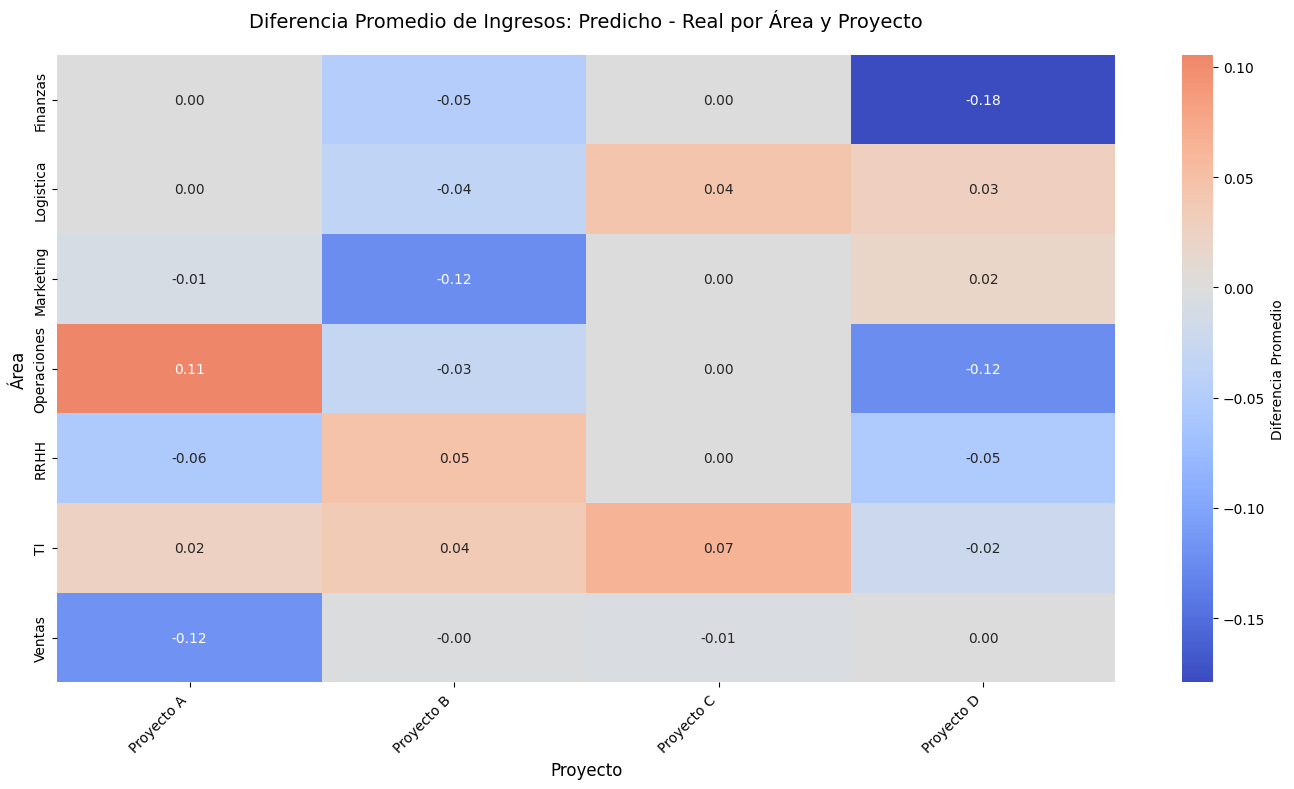


 Heatmap: Área vs Trimestre


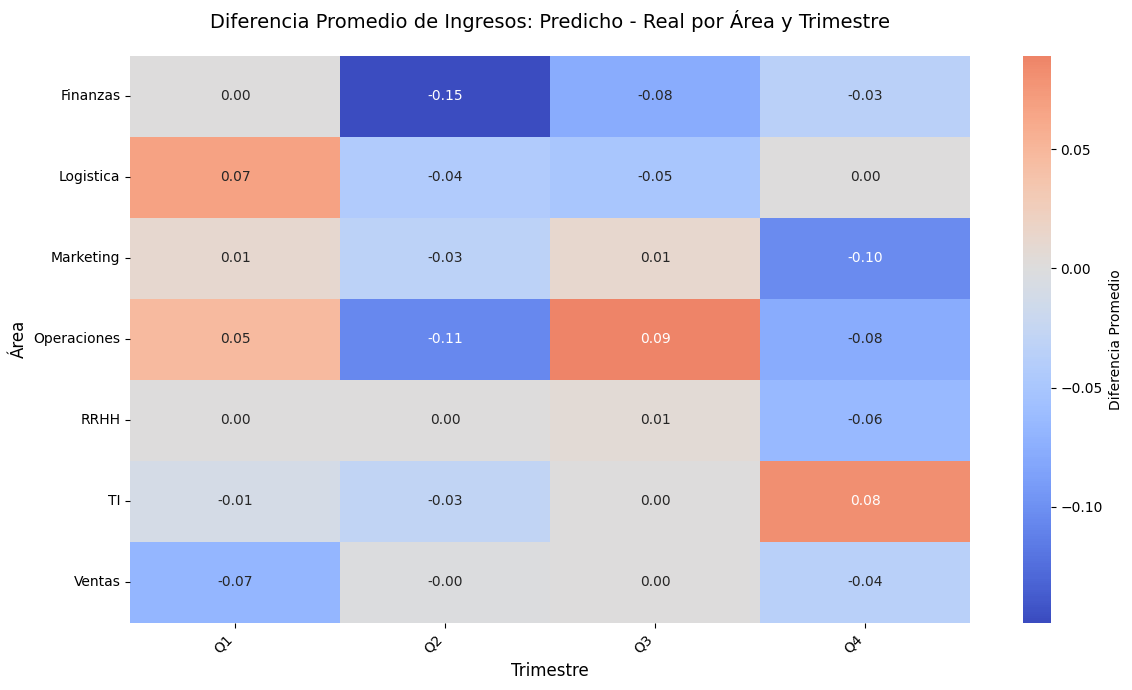


 Distribución de diferencias


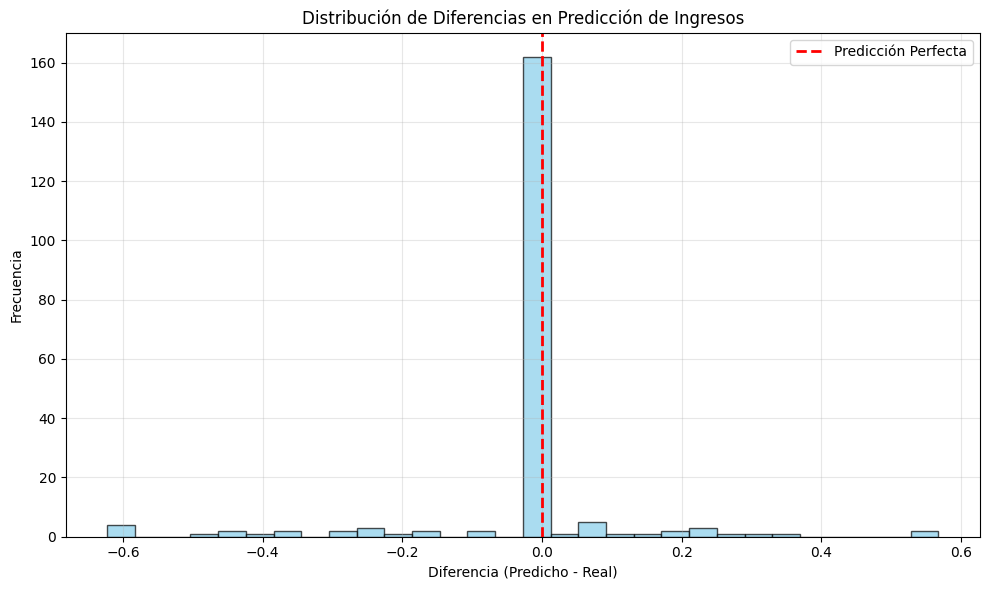

ANÁLISIS DE PREDICCIONES - CESES
ESTADÍSTICAS DE CESES:
• Diferencia promedio: -0.01
• Error absoluto promedio: 0.04
• Máxima sobre-predicción: 0.35
• Máxima sub-predicción: -0.60
• Exactitud (diferencia = 0): 160 registros

 Heatmap: Área vs Proyecto


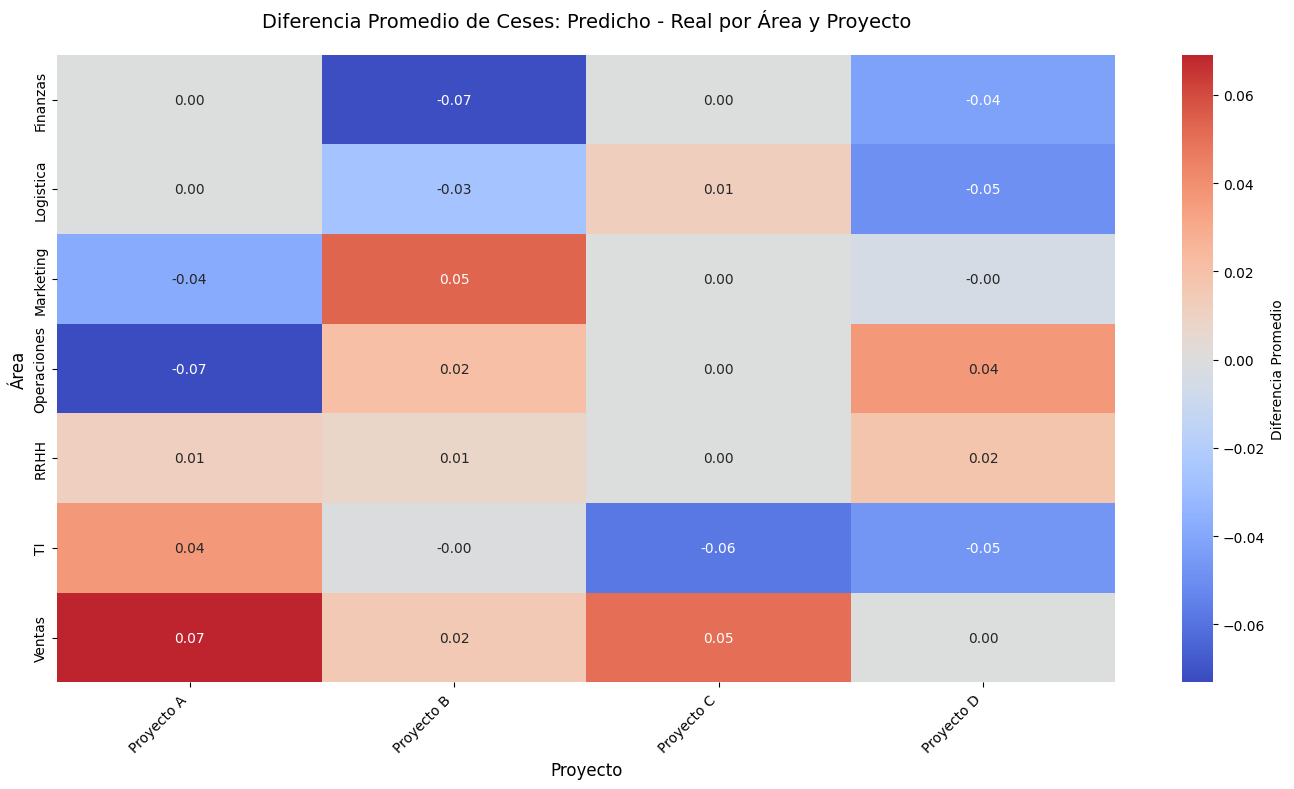


 Heatmap: Área vs Trimestre


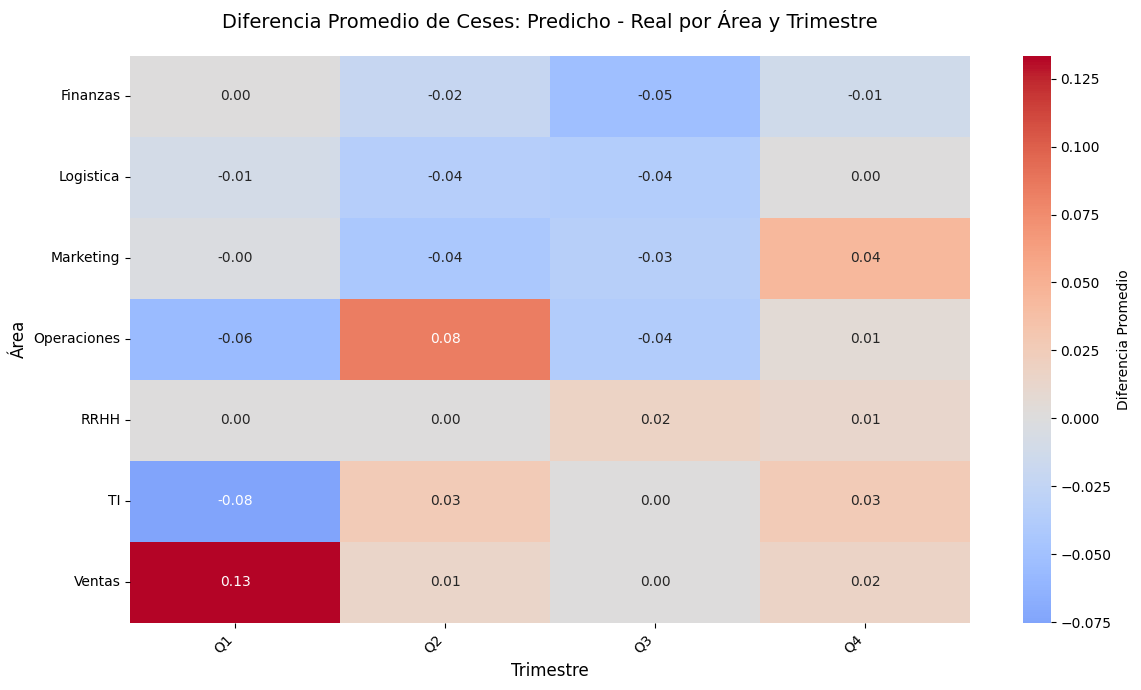


 Distribución de diferencias


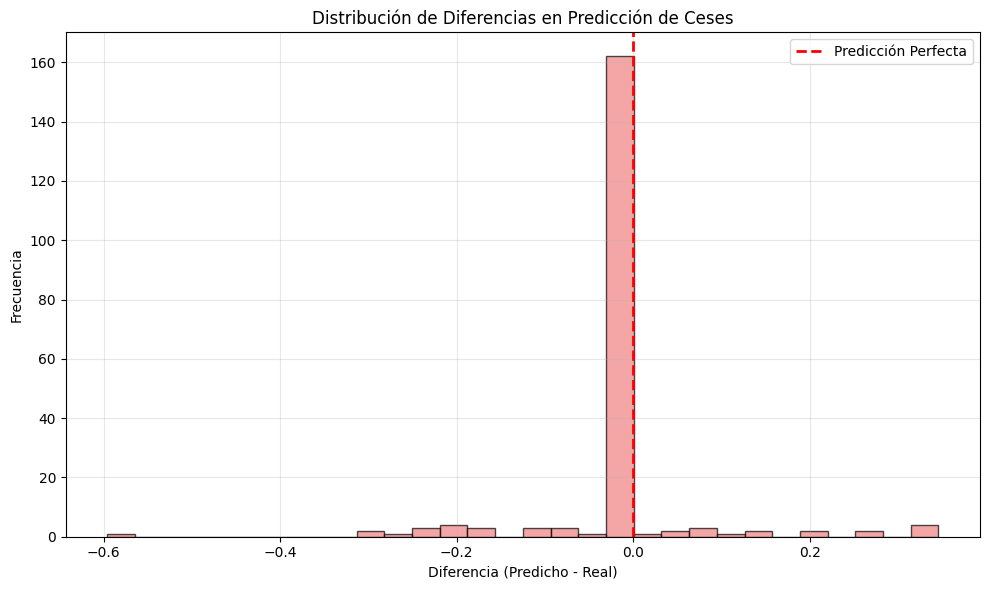


COMPARATIVA FINAL DE MODELOS
INGRESOS:
   • MAE: 0.05
   • Exactitud: 80.0%
   • Tendencia: Sub-predice

 CESES:
   • MAE: 0.04
   • Exactitud: 80.0%
   • Tendencia: Sub-predice

 ANÁLISIS COMPLETADO EXITOSAMENTE


In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# =====================================================
# CLASE PARA ANÁLISIS DE PREDICCIONES
# =====================================================
class PredictionAnalyzer:
    """
    Una clase para encapsular el análisis y la visualización de un modelo de predicción.
    """
    def __init__(self, df_base, y_test, y_pred, target_name):
        self.df_base = df_base
        self.y_test = y_test
        self.y_pred = y_pred
        self.target_name = target_name
        self.df_forecast = self._create_forecast_df()

    # Dentro de la clase PredictionAnalyzer
    def _create_forecast_df(self):
        """
        Método auxiliar para crear el DataFrame de pronóstico de manera segura.
        """
        # Crear un DataFrame temporal con los valores reales y predichos
        temp_df = pd.DataFrame({
            f'{self.target_name}_Predicho': self.y_pred,
            f'{self.target_name}_Real': self.y_test
        }, index=self.y_test.index)

        # Unir el DataFrame original con el DataFrame temporal usando los índices
        df_forecast = self.df_base.merge(
            temp_df,
            left_index=True,
            right_index=True,
            how='left'
        )

        # Rellenar solo las columnas numéricas que tienen NaN
        cols_to_fill = [f'{self.target_name}_Predicho', f'{self.target_name}_Real']
        df_forecast[cols_to_fill] = df_forecast[cols_to_fill].fillna(0)

        # Calcular la diferencia
        df_forecast['Diferencia'] = df_forecast[f'{self.target_name}_Predicho'] - df_forecast[f'{self.target_name}_Real']

        return df_forecast



    def display_statistics(self):
        """Muestra estadísticas descriptivas de la predicción."""
        print("="*50)
        print(f"ANÁLISIS DE PREDICCIONES - {self.target_name.upper()}")
        print("="*50)
        print(f"ESTADÍSTICAS DE {self.target_name.upper()}:")
        print(f"• Diferencia promedio: {self.df_forecast['Diferencia'].mean():.2f}")
        print(f"• Error absoluto promedio: {self.df_forecast['Diferencia'].abs().mean():.2f}")
        print(f"• Máxima sobre-predicción: {self.df_forecast['Diferencia'].max():.2f}")
        print(f"• Máxima sub-predicción: {self.df_forecast['Diferencia'].min():.2f}")
        print(f"• Exactitud (diferencia = 0): {(self.df_forecast['Diferencia'] == 0).sum()} registros")

    def plot_heatmap(self, groupby_cols):
        """Genera y muestra un heatmap para las diferencias."""
        print(f"\n Heatmap: {' vs '.join(groupby_cols)}")
        title = f'Diferencia Promedio de {self.target_name}: Predicho - Real por ' + ' y '.join(groupby_cols)
        df_diff = self.df_forecast.groupby(groupby_cols)['Diferencia'].mean().reset_index()

        if df_diff.empty:
            print("No hay datos para generar el heatmap.")
            return

        df_pivot = df_diff.pivot(index=groupby_cols[0], columns=groupby_cols[1], values='Diferencia')
        plt.figure(figsize=(14, 8) if len(groupby_cols) == 2 and groupby_cols[1] == 'Proyecto' else (12, 7))
        sns.heatmap(df_pivot, annot=True, fmt=".2f", cmap="coolwarm", center=0, cbar_kws={'label': 'Diferencia Promedio'})
        plt.title(title, fontsize=14, pad=20)
        plt.ylabel(groupby_cols[0], fontsize=12)
        plt.xlabel(groupby_cols[1], fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    def plot_distribution(self, color):
        """Genera y muestra el histograma de las diferencias."""
        print("\n Distribución de diferencias")
        plt.figure(figsize=(10, 6))
        plt.hist(self.df_forecast['Diferencia'], bins=30, alpha=0.7, color=color, edgecolor='black')
        plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Predicción Perfecta')
        plt.xlabel('Diferencia (Predicho - Real)')
        plt.ylabel('Frecuencia')
        plt.title(f'Distribución de Diferencias en Predicción de {self.target_name}')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

# =====================================================
# EJECUCIÓN PRINCIPAL CON MANEJO DE VARIABLES REFACTORIZADO
# =====================================================

def run_step_3():
    """Ejecuta el paso 3 completo con el enfoque POO."""
    print("EJECUTANDO PASO 3: ANÁLISIS Y VISUALIZACIÓN DE RESULTADOS (POO)")
    print("="*60)

    # 1️ VERIFICAR Y RECUPERAR VARIABLES DEL PASO 2
    print("Verificando variables del Paso 2...")

    # Lista de variables necesarias
    required_vars = ['df', 'y_test_i', 'y_pred_i', 'y_test_c', 'y_pred_c']

    try:
        # Recuperar variables de forma segura
        retrieved_vars = {var: global_vars[var] for var in required_vars}
    except KeyError as e:
        print(f"Error: La variable '{e.args[0]}' no se encuentra en `global_vars`.")
        print("Asegúrate de ejecutar el Paso 2 completo antes de este script.")
        return

    print("Todas las variables disponibles")

    # Asignar variables para una mejor legibilidad en el código siguiente
    df = retrieved_vars['df']
    y_test_i = retrieved_vars['y_test_i']
    y_pred_i = retrieved_vars['y_pred_i']
    y_test_c = retrieved_vars['y_test_c']
    y_pred_c = retrieved_vars['y_pred_c']

    print(f"DataFrame: {df.shape}")
    print(f"Test Ingresos: {len(y_test_i)} samples")
    print(f"Pred Ingresos: {len(y_pred_i)} predictions")
    print(f"Test Ceses: {len(y_test_c)} samples")
    print(f"Pred Ceses: {len(y_pred_c)} predictions")

    # 2️ ANÁLISIS Y VISUALIZACIÓN CON OBJETOS
    # Analizar Ingresos
    ingresos_analyzer = PredictionAnalyzer(df, y_test_i, y_pred_i, 'Ingresos')
    ingresos_analyzer.display_statistics()
    ingresos_analyzer.plot_heatmap(['Área', 'Proyecto'])
    ingresos_analyzer.plot_heatmap(['Área', 'Trimestre'])
    ingresos_analyzer.plot_distribution('skyblue')

    # Analizar Ceses
    ceses_analyzer = PredictionAnalyzer(df, y_test_c, y_pred_c, 'Ceses')
    ceses_analyzer.display_statistics()
    ceses_analyzer.plot_heatmap(['Área', 'Proyecto'])
    ceses_analyzer.plot_heatmap(['Área', 'Trimestre'])
    ceses_analyzer.plot_distribution('lightcoral')

    # 3️ COMPARATIVA FINAL
    print("\n" + "="*60)
    print("COMPARATIVA FINAL DE MODELOS")
    print("="*60)

    print("INGRESOS:")
    print(f"   • MAE: {ingresos_analyzer.df_forecast['Diferencia'].abs().mean():.2f}")
    print(f"   • Exactitud: {(ingresos_analyzer.df_forecast['Diferencia'] == 0).mean()*100:.1f}%")
    print(f"   • Tendencia: {'Sobre-predice' if ingresos_analyzer.df_forecast['Diferencia'].mean() > 0 else 'Sub-predice'}")

    print("\n CESES:")
    print(f"   • MAE: {ceses_analyzer.df_forecast['Diferencia'].abs().mean():.2f}")
    print(f"   • Exactitud: {(ceses_analyzer.df_forecast['Diferencia'] == 0).mean()*100:.1f}%")
    print(f"   • Tendencia: {'Sobre-predice' if ceses_analyzer.df_forecast['Diferencia'].mean() > 0 else 'Sub-predice'}")

    print("\n ANÁLISIS COMPLETADO EXITOSAMENTE")

# Ejecutar el paso
if __name__ == "__main__":
    run_step_3()

# 🔮 Paso 4: Forecast para Próximos 4 Trimestres

---

## 🎯 **¿Qué hace este paso?**

Utiliza los **modelos entrenados** del Paso 2 para generar **predicciones futuras** de ingresos y ceses de personal para los próximos 4 trimestres, incluyendo **rangos de confianza** basados en el error histórico del modelo.

## 🔄 **Proceso de Forecasting**

### **📋 Componentes utilizados:**
- **Modelos entrenados**: RNA de ingresos y ceses del Paso 2
- **Preprocessors**: Scalers y encoders persistidos
- **Datos base**: Últimas observaciones por área y proyecto
- **MAE histórico**: Para calcular rangos de confianza

### **⚙️ Metodología aplicada:**
1. **Extracción de baseline**: Últimos valores por área/proyecto
2. **Proyección temporal**: Generación de 4 trimestres futuros
3. **Crecimiento simulado**: Incremento del 5% por trimestre en variables operacionales
4. **Transformación consistente**: Mismo preprocesamiento que en entrenamiento
5. **Predicción con intervalos**: Valores puntuales + rangos de confianza

---

## 📊 **Estructura del Forecast**

### **🎯 Variables predichas:**

| Variable | Descripción | Rango de Confianza |
|----------|-------------|-------------------|
| **Ingresos_Predicho** | Contrataciones esperadas | ± MAE histórico |
| **Ceses_Predicho** | Renuncias esperadas | ± MAE histórico |

### **📅 Dimensiones del análisis:**
- **Temporal**: Q1, Q2, Q3, Q4 del próximo año
- **Organizacional**: Por área y proyecto específico
- **Cobertura**: Todas las combinaciones área-proyecto activas

### **💾 Salidas generadas:**
- **Archivo CSV**: `forecast_rrhh.csv` con predicciones detalladas
- **DataFrame**: Resultados en memoria para análisis adicional
- **Estadísticas resumen**: Totales por trimestre y métricas generales

---

## 📈 **Interpretación de Resultados**

### **🔍 Cómo usar las predicciones:**
- **Valor puntual**: Predicción más probable del modelo
- **Rango inferior**: Escenario conservador (predicción - MAE)
- **Rango superior**: Escenario optimista (predicción + MAE)
- **Tendencia trimestral**: Evolución esperada a lo largo del año

### **⚠️ Consideraciones importantes:**
- **Crecimiento simulado**: 5% trimestral en variables operacionales
- **Baseline actual**: Basado en últimas observaciones reales
- **Incertidumbre**: Rangos reflejan precisión histórica del modelo
- **Contexto**: Predicciones asumen condiciones similares a entrenamiento

---

## 💼 **Casos de Uso**

### **👥 Para Recursos Humanos:**
- **Planificación de contrataciones**: Cuántas personas contratar por área
- **Gestión de retención**: Anticipar áreas con alta rotación
- **Presupuesto anual**: Estimar costos de RRHH por trimestre
- **Capacidad organizacional**: Evaluar crecimiento vs pérdidas

### **📊 Para Planificación Estratégica:**
- **Asignación de recursos**: Priorizar inversión en áreas específicas
- **Timeline de proyectos**: Ajustar cronogramas según disponibilidad
- **Riesgo operacional**: Identificar trimestres críticos
- **Benchmarking**: Comparar predicciones vs targets empresariales

---

## 🔄 **Metodología de Actualización**

### **🔄 Recomendaciones de uso:**
- **Frecuencia**: Actualizar forecast al final de cada trimestre
- **Calibración**: Comparar predicciones vs resultados reales
- **Retroalimentación**: Ajustar modelos con nuevos datos
- **Monitoreo**: Seguir métricas de precisión continuamente

---

## ✅ **Entregables del Paso**

### **📁 Archivos generados:**
- `forecast_rrhh.csv`: Predicciones detalladas por área/proyecto/trimestre
- Estadísticas resumidas por consola
- Vistas previas de datos para validación rápida

### **📊 Métricas de resumen:**
- Total de ingresos/ceses predichos por trimestre
- Número de proyectos y áreas analizadas
- Rangos de confianza promedio por target

---




In [39]:
# =====================================================
# PASO 4: FORECAST PARA PRÓXIMOS 4 TRIMESTRES (REFACTORIZADO)
# =====================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error
from IPython.display import display
import joblib

print("EJECUTANDO PASO 4: FORECAST FUTURO")
print("="*50)

def run_forecast():
    """Ejecuta el forecast para los próximos trimestres de manera refactorizada."""

    # 1️ CARGAR VARIABLES NECESARIAS
    print("Cargando variables necesarias...")
    try:
        df = global_vars['df']
        scaler = joblib.load("scaler.joblib")
        encoder = joblib.load("encoder.joblib")
        model_ingresos = global_vars['model_ingresos']
        model_ceses = global_vars['model_ceses']
        X_train_i = global_vars['X_train_i']
        y_train_i = global_vars['y_train_i']
        X_train_c = global_vars['X_train_c']
        y_train_c = global_vars['y_train_c']
        print("Todas las variables cargadas correctamente")
    except Exception as e:
        print(f"Error cargando variables: {e}")
        print("Asegúrate de haber ejecutado el Paso 2 primero.")
        return None

    # 2️ CONFIGURACIÓN Y CÁLCULOS PREVIOS
    print("\nConfigurando forecast...")

    # Identificar la última observación y las columnas
    df_last = df.drop_duplicates(subset=['Área', 'Proyecto'], keep='last').copy()
    trimestres_futuros = ['Q1', 'Q2', 'Q3', 'Q4']
    anio_futuro = df['Año'].max() + 1

    # Identificar las columnas numéricas y categóricas del DataFrame original.
    numeric_cols = [col for col in df.columns if df[col].dtype in ['int64', 'float64'] and col not in ['Ingresos_Q', 'Ceses_Q', 'Año']]
    categorical_cols = ['Trimestre', 'Área', 'Proyecto']

    # Calcular MAE histórico para los rangos de confianza
    mae_i_hist = mean_absolute_error(y_train_i, model_ingresos.predict(X_train_i, verbose=0))
    mae_c_hist = mean_absolute_error(y_train_c, model_ceses.predict(X_train_c, verbose=0))

    print(f"MAE histórico - Ingresos: {mae_i_hist:.2f}")
    print(f"MAE histórico - Ceses: {mae_c_hist:.2f}")

    # 3️ GENERAR EL DATAFRAME FUTURO
    print("\nGenerando DataFrame futuro...")

    # Crear un DataFrame con las combinaciones de Área, Proyecto y Trimestre
    proyectos_unicos = df_last[['Área', 'Proyecto']]
    future_data = pd.DataFrame()
    for trimestre in trimestres_futuros:
        temp_df = proyectos_unicos.copy()
        temp_df['Trimestre'] = trimestre
        future_data = pd.concat([future_data, temp_df], ignore_index=True)

    future_data['Año'] = anio_futuro

    # Llenar las columnas numéricas con los valores de la última observación
    for col in numeric_cols:
        future_data = future_data.merge(df_last[['Área', 'Proyecto', col]], on=['Área', 'Proyecto'], how='left')

    # Aplicar el crecimiento del 5% a la dotación.
    if 'Dotacion' in future_data.columns:
        future_data['Dotacion'] = future_data['Dotacion'] * 1.05

    # 4️ PREPROCESAR Y PREDECIR EN BLOQUE
    print("Preprocesando y prediciendo...")

    # Transformar las columnas categóricas y numéricas del nuevo DataFrame.
    X_future_cat = encoder.transform(future_data[categorical_cols])
    X_future_numeric = scaler.transform(future_data[numeric_cols])

    # Combinar en un array final para la predicción del modelo
    X_final_future = np.hstack([X_future_numeric, X_future_cat])

    y_pred_i = model_ingresos.predict(X_final_future, verbose=0).flatten()
    y_pred_c = model_ceses.predict(X_final_future, verbose=0).flatten()

    # 5️ AGREGAR PREDICCIONES Y RANGOS AL DATAFRAME FINAL
    future_data['Ingresos_Predicho'] = y_pred_i
    future_data['Ceses_Predicho'] = y_pred_c

    # Calcular rangos de confianza en bloque
    future_data['Rango_Conf_Inf_Ingresos'] = np.maximum(0, future_data['Ingresos_Predicho'] - mae_i_hist)
    future_data['Rango_Conf_Sup_Ingresos'] = future_data['Ingresos_Predicho'] + mae_i_hist
    future_data['Rango_Conf_Inf_Ceses'] = np.maximum(0, future_data['Ceses_Predicho'] - mae_c_hist)
    future_data['Rango_Conf_Sup_Ceses'] = future_data['Ceses_Predicho'] + mae_c_hist

    # 6️ LIMPIEZA Y EXPORTACIÓN
    df_forecast = future_data.round(2)
    df_forecast = df_forecast[[
        'Año','Proyecto','Área','Trimestre',
        'Ingresos_Predicho','Rango_Conf_Inf_Ingresos','Rango_Conf_Sup_Ingresos',
        'Ceses_Predicho','Rango_Conf_Inf_Ceses','Rango_Conf_Sup_Ceses'
    ]].sort_values(by=['Área', 'Proyecto', 'Trimestre']).reset_index(drop=True)

    df_forecast.to_csv("forecast_rrhh.csv", index=False, encoding="utf-8-sig")

    print(f"Forecast completado! Archivo guardado: forecast_rrhh.csv")
    print(f"Total de registros: {len(df_forecast)}")

    return df_forecast

# EJECUTAR FORECAST
df_forecast_result = run_forecast()

# MOSTRAR RESULTADOS
if df_forecast_result is not None:
    print("\n" + "="*50)
    print("VISTA PREVIA DEL FORECAST")
    print("="*50)

    print("\n=== Primeras 10 filas ===")
    display(df_forecast_result.head(10))

    print("\n=== Últimas 10 filas ===")
    display(df_forecast_result.tail(10))

    # RESUMEN POR TRIMESTRE
    print("\n=== RESUMEN POR TRIMESTRE ===")
    summary_by_quarter = df_forecast_result.groupby('Trimestre').agg(
        Ingresos_Predicho=('Ingresos_Predicho', 'sum'),
        Ceses_Predicho=('Ceses_Predicho', 'sum')
    ).round(0)
    display(summary_by_quarter)

    print("PASO 4 COMPLETADO")

EJECUTANDO PASO 4: FORECAST FUTURO
Cargando variables necesarias...
Todas las variables cargadas correctamente

Configurando forecast...
MAE histórico - Ingresos: 0.20
MAE histórico - Ceses: 0.14

Generando DataFrame futuro...
Preprocesando y prediciendo...
Forecast completado! Archivo guardado: forecast_rrhh.csv
Total de registros: 112

VISTA PREVIA DEL FORECAST

=== Primeras 10 filas ===


,Año,Proyecto,Área,Trimestre,Ingresos_Predicho,Rango_Conf_Inf_Ingresos,Rango_Conf_Sup_Ingresos,Ceses_Predicho,Rango_Conf_Inf_Ceses,Rango_Conf_Sup_Ceses
0,2025,Proyecto A,Finanzas,Q1,0.84,0.64,1.04,0.90,0.76,1.04
1,2025,Proyecto A,Finanzas,Q2,0.97,0.77,1.17,0.96,0.82,1.09
2,2025,Proyecto A,Finanzas,Q3,0.89,0.69,1.09,0.94,0.80,1.08
3,2025,Proyecto A,Finanzas,Q4,0.89,0.69,1.09,1.00,0.86,1.13
4,2025,Proyecto B,Finanzas,Q1,1.80,1.60,2.00,0.84,0.70,0.98
5,2025,Proyecto B,Finanzas,Q2,1.60,1.40,1.80,0.80,0.66,0.94
6,2025,Proyecto B,Finanzas,Q3,1.91,1.71,2.11,0.71,0.58,0.85
7,2025,Proyecto B,Finanzas,Q4,1.82,1.62,2.02,0.79,0.65,0.93
8,2025,Proyecto C,Finanzas,Q1,0.45,0.25,0.65,0.51,0.37,0.65
9,2025,Proyecto C,Finanzas,Q2,0.29,0.09,0.49,0.99,0.85,1.12



=== Últimas 10 filas ===


,Año,Proyecto,Área,Trimestre,Ingresos_Predicho,Rango_Conf_Inf_Ingresos,Rango_Conf_Sup_Ingresos,Ceses_Predicho,Rango_Conf_Inf_Ceses,Rango_Conf_Sup_Ceses
102,2025,Proyecto B,Ventas,Q3,1.96,1.76,2.16,-0.04,0.00,0.10
103,2025,Proyecto B,Ventas,Q4,1.71,1.51,1.91,0.18,0.04,0.32
104,2025,Proyecto C,Ventas,Q1,0.58,0.38,0.78,0.14,0.00,0.28
105,2025,Proyecto C,Ventas,Q2,0.79,0.59,0.99,-0.01,0.00,0.12
106,2025,Proyecto C,Ventas,Q3,0.75,0.55,0.95,0.02,0.00,0.16
107,2025,Proyecto C,Ventas,Q4,0.74,0.54,0.94,0.08,0.00,0.22
108,2025,Proyecto D,Ventas,Q1,0.82,0.62,1.02,1.68,1.55,1.82
109,2025,Proyecto D,Ventas,Q2,0.81,0.61,1.01,1.75,1.61,1.89
110,2025,Proyecto D,Ventas,Q3,1.02,0.82,1.22,1.81,1.67,1.94
111,2025,Proyecto D,Ventas,Q4,0.55,0.35,0.75,1.77,1.63,1.91



=== RESUMEN POR TRIMESTRE ===


,Ingresos_Predicho,Ceses_Predicho
Trimestre,,
Q1,32.0,26.0
Q2,35.0,27.0
Q3,32.0,26.0
Q4,32.0,26.0


PASO 4 COMPLETADO


# 📊 Paso 5: Visualización de Predicciones Futuras

---

## 🎯 **¿Qué hace este paso?**

Genera **visualizaciones comprensivas** del forecast creado en el Paso 4, creando **tablas resumen** y **heatmaps interactivos** que faciliten la interpretación estratégica de las predicciones futuras.

## 📈 **Análisis Generados**

### **📋 Tablas resumen:**
- **Predicciones puntuales**: Valores esperados por área/trimestre/proyecto
- **Rangos de confianza**: Límites inferior y superior de las predicciones
- **Agregación por dimensiones**: Sumas totales para análisis comparativo

### **🎨 Heatmaps visualizan:**
- **Intensidad de predicciones**: Colores proporcionales a magnitud
- **Patrones espaciales**: Hotspots por área y dimensión temporal
- **Valores numéricos**: Anotaciones en cada celda para precisión

---

## 🔍 **Dimensiones de Análisis**

### **📅 Por Área y Trimestre:**
- **Evolución trimestral** de cada área organizacional
- **Identificación de trimestres críticos** con alta actividad
- **Planificación temporal** de recursos humanos

### **🏢 Por Área y Proyecto:**
- **Distribución de carga** entre diferentes proyectos
- **Priorización de proyectos** con mayor movimiento de personal
- **Asignación estratégica** de recursos por iniciativa

---

## 💡 **Interpretación de Resultados**

### **🔥 Escala de colores en heatmaps:**
- **🔴 Rojo intenso**: Valores altos (mayor actividad esperada)
- **⚪ Gris claro**: Valores promedio (actividad normal)
- **🔵 Azul intenso**: Valores bajos (menor actividad esperada)

### **📊 Componentes de las tablas:**
- **Valor predicho**: Estimación más probable del modelo
- **Rango inferior**: Escenario conservador (mínimo esperado)
- **Rango superior**: Escenario optimista (máximo esperado)

---

## 🎯 **Casos de Uso**

### **👥 Para Recursos Humanos:**
- **Planificación trimestral**: Cuándo y dónde contratar o retener personal
- **Gestión proactiva**: Anticipar áreas con alta rotación
- **Presupuesto dinámico**: Ajustar recursos por período

### **📋 Para Project Management:**
- **Staffing de proyectos**: Disponibilidad de recursos por iniciativa
- **Gestión de timeline**: Ajustar cronogramas según disponibilidad prevista

---

## 📊 **Salidas del Paso**

### **🎨 Visualizaciones:**
- 4 tablas resumen detalladas (ingresos/ceses por área-trimestre y área-proyecto)
- 4 heatmaps con escalas optimizadas para comparación
- Formato consistente y listo para presentación

### **📋 Información clave:**
- Totales agregados por dimensión de análisis
- Rangos de confianza para gestión de incertidumbre
- Patrones visuales para identificación rápida de tendencias




📈 PASO 5: VISUALIZACIÓN DE RESULTADOS CON POO
=== Resumen de Ingresos por Área, Trimestre ===


,Área,Trimestre,Ingresos_Predicho,Rango_Conf_Inf_Ingresos,Rango_Conf_Sup_Ingresos
0,Finanzas,Q1,4.95,4.15,5.76
1,Finanzas,Q2,4.73,3.93,5.53
2,Finanzas,Q3,4.37,3.77,5.17
3,Finanzas,Q4,4.39,3.79,5.19
4,Logistica,Q1,5.24,4.44,6.04
5,Logistica,Q2,5.73,4.93,6.53
6,Logistica,Q3,4.69,3.89,5.49
7,Logistica,Q4,5.13,4.32,5.93
8,Marketing,Q1,3.51,3.70,4.31
9,Marketing,Q2,4.37,4.14,5.17


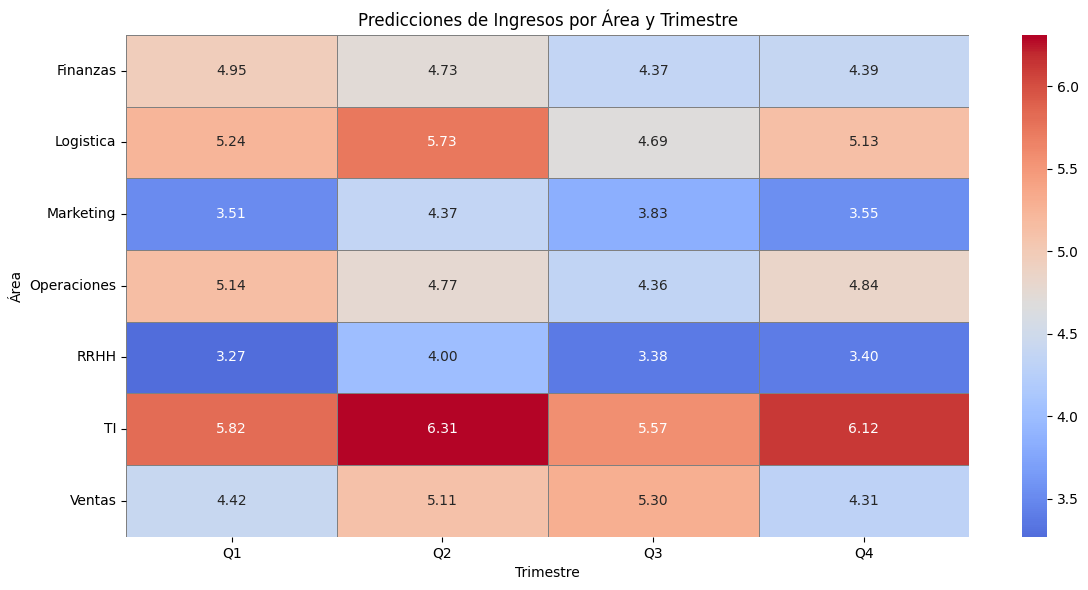

=== Resumen de Ceses por Área, Trimestre ===


,Área,Trimestre,Ceses_Predicho,Rango_Conf_Inf_Ceses,Rango_Conf_Sup_Ceses
0,Finanzas,Q1,2.30,1.83,2.86
1,Finanzas,Q2,2.75,2.33,3.29
2,Finanzas,Q3,2.71,2.35,3.27
3,Finanzas,Q4,2.43,1.99,2.98
4,Logistica,Q1,2.97,2.62,3.52
5,Logistica,Q2,3.32,2.77,3.87
6,Logistica,Q3,3.22,2.85,3.77
7,Logistica,Q4,3.43,2.92,3.99
8,Marketing,Q1,7.68,7.47,8.23
9,Marketing,Q2,7.64,7.28,8.19


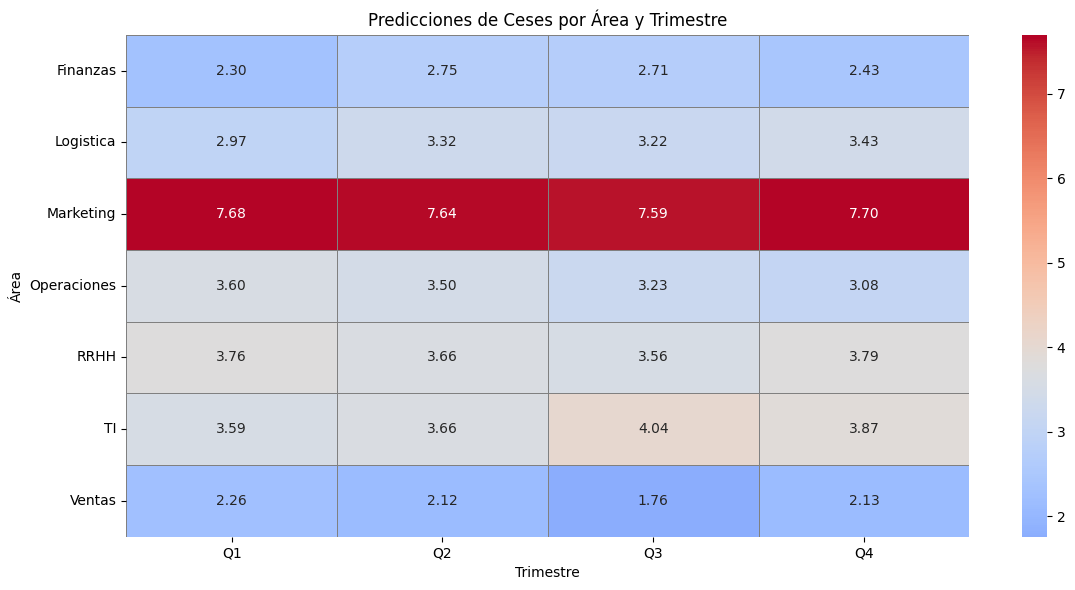

=== Resumen de Ingresos por Área, Proyecto ===


,Área,Proyecto,Ingresos_Predicho,Rango_Conf_Inf_Ingresos,Rango_Conf_Sup_Ingresos
0,Finanzas,Proyecto A,3.59,2.79,4.39
1,Finanzas,Proyecto B,7.13,6.33,7.93
2,Finanzas,Proyecto C,0.74,0.34,1.54
3,Finanzas,Proyecto D,6.98,6.18,7.79
4,Logistica,Proyecto A,8.48,7.68,9.28
5,Logistica,Proyecto B,3.75,2.95,4.55
6,Logistica,Proyecto C,6.71,5.90,7.51
7,Logistica,Proyecto D,1.85,1.05,2.65
8,Marketing,Proyecto A,-0.94,0.00,-0.14
9,Marketing,Proyecto B,6.67,5.85,7.47


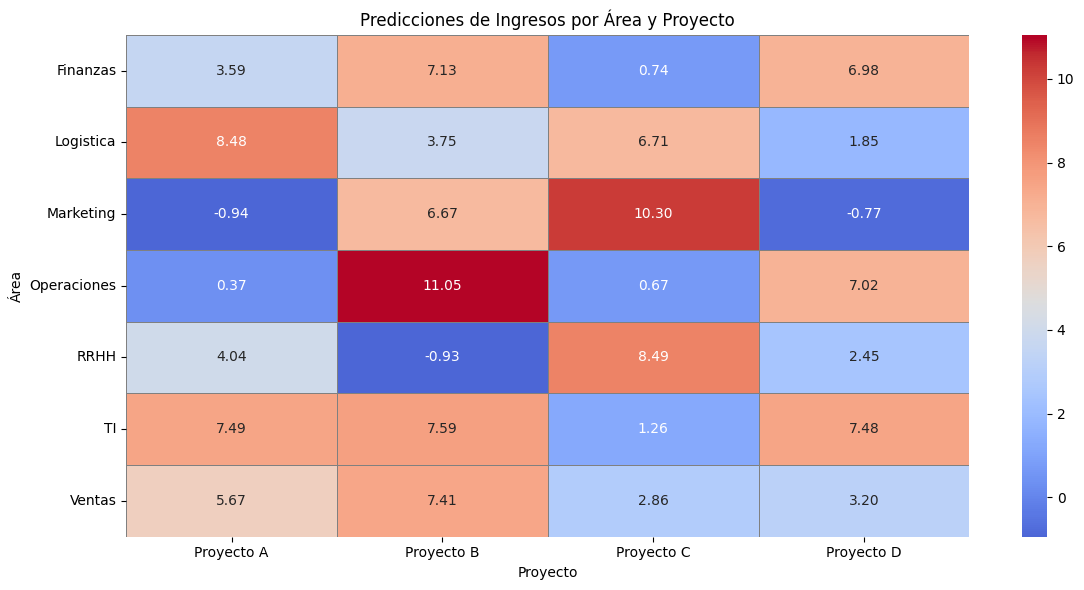

=== Resumen de Ceses por Área, Proyecto ===


,Área,Proyecto,Ceses_Predicho,Rango_Conf_Inf_Ceses,Rango_Conf_Sup_Ceses
0,Finanzas,Proyecto A,3.80,3.24,4.34
1,Finanzas,Proyecto B,3.14,2.59,3.70
2,Finanzas,Proyecto C,3.21,2.67,3.76
3,Finanzas,Proyecto D,0.04,0.00,0.60
4,Logistica,Proyecto A,8.28,7.73,8.84
5,Logistica,Proyecto B,0.69,0.21,1.25
6,Logistica,Proyecto C,0.28,0.08,0.84
7,Logistica,Proyecto D,3.69,3.14,4.22
8,Marketing,Proyecto A,0.40,0.09,0.93
9,Marketing,Proyecto B,13.03,12.49,13.59


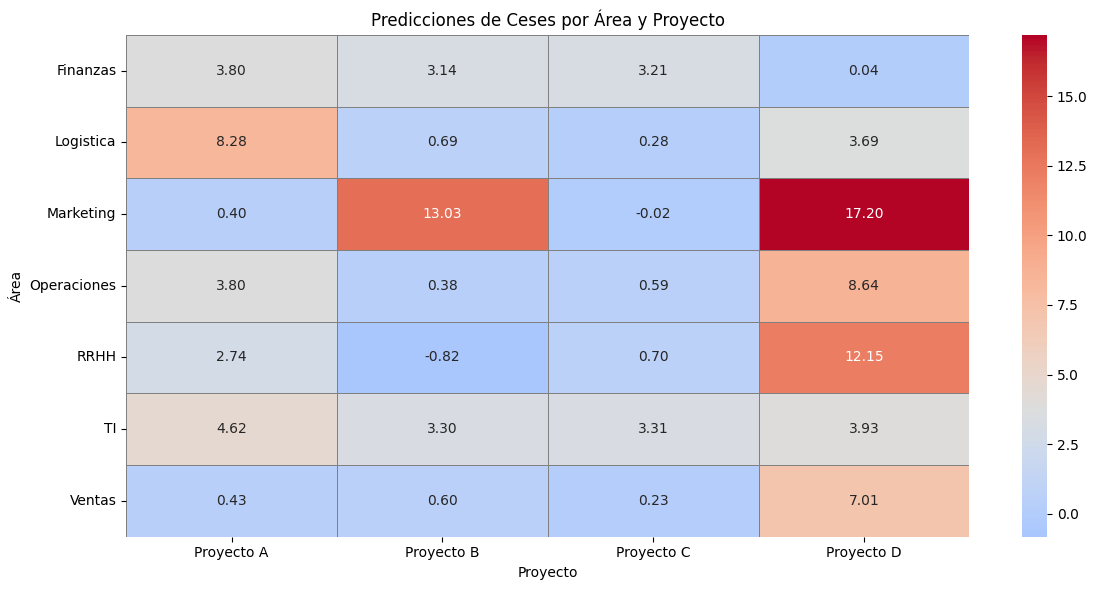


✅ PASO 5 COMPLETADO


In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

class PredictionVisualizer:
    """
    Una clase para encapsular la lógica de visualización y resumen
    de las predicciones del modelo.
    """
    def __init__(self, df):
        """
        Inicializa la clase con el DataFrame de pronósticos.

        Args:
            df (pd.DataFrame): DataFrame que contiene las predicciones del modelo.
        """
        self.df = df

    def generate_summary(self, groupby_cols, target_cols, title_suffix):
        """
        Genera y muestra una tabla resumen de los datos.

        Args:
            groupby_cols (list): Columnas para agrupar (ej. ['Área', 'Trimestre']).
            target_cols (list): Columnas a resumir (ej. ['Ingresos_Predicho', ...]).
            title_suffix (str): Sufijo para el título del reporte.
        """
        df_summary = self.df.groupby(groupby_cols).agg({
            col: 'sum' for col in target_cols
        }).reset_index()

        df_summary[target_cols] = df_summary[target_cols].round(2)
        df_summary = df_summary.sort_values(groupby_cols).reset_index(drop=True)

        print(f"=== Resumen de {title_suffix} por {', '.join(groupby_cols)} ===")
        display(df_summary)
        print()

    def generate_heatmap(self, groupby_cols, target_col, title_suffix):
        """
        Genera y muestra un heatmap de las predicciones.

        Args:
            groupby_cols (list): Columnas para agrupar y usar en los ejes del heatmap.
            target_col (str): Columna de la predicción a visualizar.
            title_suffix (str): Sufijo para el título del gráfico.
        """
        df_summary = self.df.groupby(groupby_cols).agg({
            target_col: 'sum'
        }).reset_index()

        # El primer elemento de groupby_cols se usa como el eje Y (índice),
        # y el segundo como el eje X (columnas).
        pivot_table = df_summary.pivot(
            index=groupby_cols[0],
            columns=groupby_cols[1],
            values=target_col
        )

        plt.figure(figsize=(12, 6))
        sns.heatmap(
            pivot_table,
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            center=pivot_table.values.mean(),
            linewidths=0.5,
            linecolor='gray'
        )
        plt.title(f"Predicciones de {title_suffix} por {groupby_cols[0]} y {groupby_cols[1]}")
        plt.ylabel(groupby_cols[0])
        plt.xlabel(groupby_cols[1])
        plt.tight_layout()
        plt.show()

def run_step_3():
    """Ejecuta todo el Paso 3: Visualización de resultados."""
    print("="*60)
    print("📈 PASO 5: VISUALIZACIÓN DE RESULTADOS CON POO")
    print("="*60)

    # 1. Cargar datos una sola vez
    df_forecast = pd.read_csv("forecast_rrhh.csv")

    # 2. Instanciar la clase PredictionVisualizer
    visualizer = PredictionVisualizer(df_forecast)

    # 3. Generar todos los reportes usando los métodos de la clase

    # Ingresos por Área y Trimestre
    visualizer.generate_summary(
        ['Área', 'Trimestre'],
        ['Ingresos_Predicho', 'Rango_Conf_Inf_Ingresos', 'Rango_Conf_Sup_Ingresos'],
        'Ingresos'
    )
    visualizer.generate_heatmap(['Área', 'Trimestre'], 'Ingresos_Predicho', 'Ingresos')

    # Ceses por Área y Trimestre
    visualizer.generate_summary(
        ['Área', 'Trimestre'],
        ['Ceses_Predicho', 'Rango_Conf_Inf_Ceses', 'Rango_Conf_Sup_Ceses'],
        'Ceses'
    )
    visualizer.generate_heatmap(['Área', 'Trimestre'], 'Ceses_Predicho', 'Ceses')

    # Ingresos por Área y Proyecto
    visualizer.generate_summary(
        ['Área', 'Proyecto'],
        ['Ingresos_Predicho', 'Rango_Conf_Inf_Ingresos', 'Rango_Conf_Sup_Ingresos'],
        'Ingresos'
    )
    visualizer.generate_heatmap(['Área', 'Proyecto'], 'Ingresos_Predicho', 'Ingresos')

    # Ceses por Área y Proyecto
    visualizer.generate_summary(
        ['Área', 'Proyecto'],
        ['Ceses_Predicho', 'Rango_Conf_Inf_Ceses', 'Rango_Conf_Sup_Ceses'],
        'Ceses'
    )
    visualizer.generate_heatmap(['Área', 'Proyecto'], 'Ceses_Predicho', 'Ceses')

    print("\n✅ PASO 5 COMPLETADO")

if __name__ == "__main__":
    run_step_3()

# 💰 Paso 6: Generación de Presupuesto RRHH

---

## 🎯 **¿Qué hace este paso?**

Convierte las **predicciones numéricas** del Paso 4 en un **presupuesto financiero** para recursos humanos, calculando los costos asociados a ingresos y ceses proyectados utilizando datos históricos de costos por área.

## 🔄 **Proceso de Generación**

### **📊 Componentes utilizados:**
- **Datos históricos**: `dataset_contrataciones.csv` con costos por empleado
- **Predicciones futuras**: `forecast_rrhh.csv` del Paso 4
- **Costos promedio**: Calculados por área organizacional

### **⚙️ Metodología aplicada:**
1. **Cálculo de costos base**: Promedio histórico por área
2. **Merge de datos**: Combinación de predicciones con costos
3. **Proyección financiera**: Multiplicación de cantidades × costos unitarios
4. **Exportación**: Presupuesto en formato Excel para uso empresarial

---

## 💸 **Estructura del Presupuesto**

### **📋 Variables calculadas:**

| Variable | Descripción | Fórmula |
|----------|-------------|---------|
| **Presupuesto_Ingresos** | Costo total de contrataciones | Ingresos_Predicho × Costo_Promedio_Empleado |
| **Presupuesto_Ceses** | Costo total de rotación | Ceses_Predicho × Costo_Promedio_Empleado |
| **Costo_Promedio_Empleado** | Costo unitario por área | Promedio histórico del área |

### **🎯 Dimensiones del presupuesto:**
- **Temporal**: Por trimestre del próximo año
- **Organizacional**: Diferenciado por área y proyecto
- **Financiero**: Montos en moneda local con 2 decimales

---

## 📊 **Interpretación del Presupuesto**

### **💰 Presupuesto de Ingresos:**
- **Inversión en contratación**: Costos de reclutamiento, onboarding y primeros salarios
- **Crecimiento organizacional**: Inversión para expansión de equipos
- **Planificación de cash flow**: Desembolsos esperados por trimestre

### **📉 Presupuesto de Ceses:**
- **Costos de rotación**: Liquidaciones, reemplazos y pérdida de productividad
- **Gestión de riesgo**: Provisiones para rotación natural
- **Optimización**: Identificar áreas con altos costos de rotación

---

## 🎯 **Casos de Uso**

### **💼 Para Finanzas:**
- **Planificación presupuestaria**: Asignación anual de recursos RRHH
- **Control de costos**: Monitoreo de gastos vs presupuesto aprobado
- **Forecasting financiero**: Proyecciones de flujo de caja

### **👥 Para Recursos Humanos:**
- **Justificación de inversión**: Soporte cuantitativo para solicitudes de presupuesto
- **Estrategia de retención**: Comparar costos de rotación vs inversión en retención
- **Priorización**: Enfocar esfuerzos en áreas con mayor impacto financiero

---

## 📁 **Entregables del Paso**

### **📊 Archivo Excel generado:**
- `presupuesto_rrhh.xlsx`: Presupuesto detallado por área, proyecto y trimestre
- **Formato empresarial**: Listo para presentación a directorio
- **Datos estructurados**: Fácil integración con sistemas financieros

### **📈 Información incluida:**
- Predicciones numéricas originales
- Costos promedio históricos por área
- Presupuestos calculados para ingresos y ceses
- Totales agregados para análisis ejecutivo

---


In [42]:
import pandas as pd
from IPython.display import display
import os

# =====================================================
# CLASE PARA EL PASO 6
# =====================================================

class BudgetGenerator:
    """
    Una clase para generar el presupuesto de RRHH a partir de datos históricos
    y pronósticos.
    """
    def __init__(self, historical_data_path, forecast_data_path):
        self.historical_data_path = historical_data_path
        self.forecast_data_path = forecast_data_path
        self.df_hist = None
        self.df_forecast = None
        self.df_costo = None
        self.df_presupuesto = None

    def load_data(self):
        """Carga los datasets necesarios."""
        print("Cargando datos...")
        try:
            self.df_hist = pd.read_csv(self.historical_data_path)
            self.df_forecast = pd.read_csv(self.forecast_data_path)
            return True
        except FileNotFoundError as e:
            print(f"Error al cargar archivos: {e}")
            return False

    def calculate_avg_cost(self):
        """Calcula el costo promedio por Área."""
        if self.df_hist is None:
            print("Datos históricos no cargados.")
            return
        print("Calculando costo promedio por Área...")
        self.df_costo = self.df_hist.groupby(['Área']).agg({
            'Costo_Promedio_Empleado': 'mean'
        }).reset_index()

    def generate_budget(self):
        """Genera el presupuesto final."""
        if self.df_forecast is None or self.df_costo is None:
            print("Datos de pronóstico o costos promedio no disponibles.")
            return
        print("Generando presupuesto...")
        self.df_presupuesto = self.df_forecast.merge(self.df_costo, on=['Área'], how='left')
        self.df_presupuesto['Presupuesto_Ingresos'] = self.df_presupuesto['Ingresos_Predicho'] * self.df_presupuesto['Costo_Promedio_Empleado']
        self.df_presupuesto['Presupuesto_Ceses'] = self.df_presupuesto['Ceses_Predicho'] * self.df_presupuesto['Costo_Promedio_Empleado']

        cols_redondear = ['Ingresos_Predicho', 'Ceses_Predicho', 'Costo_Promedio_Empleado',
                          'Presupuesto_Ingresos', 'Presupuesto_Ceses']
        self.df_presupuesto[cols_redondear] = self.df_presupuesto[cols_redondear].round(2)

    def export_and_display(self, output_path="presupuesto_rrhh.xlsx"):
        """Exporta el presupuesto y lo muestra."""
        if self.df_presupuesto is None:
            print("Presupuesto no generado.")
            return
        print(f"Exportando a: {os.path.abspath(output_path)}")
        self.df_presupuesto.to_excel(output_path, index=False)

        print("\n=== Tabla final de Presupuesto RRHH ===")
        display(self.df_presupuesto)
        print(f"\nTotal de registros: {len(self.df_presupuesto)}")

def run_step_6_poo():
    """Función principal para ejecutar el Paso 4."""
    print("="*60)
    print("PASO 6: GENERACIÓN DE PRESUPUESTO RRHH")
    print("="*60)

    generator = BudgetGenerator(
        historical_data_path="dataset_contrataciones.csv",
        forecast_data_path="forecast_rrhh.csv"
    )

    if generator.load_data():
        generator.calculate_avg_cost()
        generator.generate_budget()
        generator.export_and_display()

    print("PASO 6 COMPLETADO")

# Ejecutar el paso 6
if __name__ == "__main__":
    run_step_6_poo()



PASO 6: GENERACIÓN DE PRESUPUESTO RRHH
Cargando datos...
Calculando costo promedio por Área...
Generando presupuesto...
Exportando a: /content/presupuesto_rrhh.xlsx

=== Tabla final de Presupuesto RRHH ===


,Año,Proyecto,Área,Trimestre,Ingresos_Predicho,Rango_Conf_Inf_Ingresos,Rango_Conf_Sup_Ingresos,Ceses_Predicho,Rango_Conf_Inf_Ceses,Rango_Conf_Sup_Ceses,Costo_Promedio_Empleado,Presupuesto_Ingresos,Presupuesto_Ceses
0,2025,Proyecto A,Finanzas,Q1,0.84,0.64,1.04,0.90,0.76,1.04,2657.63,2232.41,2391.87
1,2025,Proyecto A,Finanzas,Q2,0.97,0.77,1.17,0.96,0.82,1.09,2657.63,2577.90,2551.32
2,2025,Proyecto A,Finanzas,Q3,0.89,0.69,1.09,0.94,0.80,1.08,2657.63,2365.29,2498.17
3,2025,Proyecto A,Finanzas,Q4,0.89,0.69,1.09,1.00,0.86,1.13,2657.63,2365.29,2657.63
4,2025,Proyecto B,Finanzas,Q1,1.80,1.60,2.00,0.84,0.70,0.98,2657.63,4783.73,2232.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,2025,Proyecto C,Ventas,Q4,0.74,0.54,0.94,0.08,0.00,0.22,2557.81,1892.78,204.62
108,2025,Proyecto D,Ventas,Q1,0.82,0.62,1.02,1.68,1.55,1.82,2557.81,2097.40,4297.12
109,2025,Proyecto D,Ventas,Q2,0.81,0.61,1.01,1.75,1.61,1.89,2557.81,2071.82,4476.16
110,2025,Proyecto D,Ventas,Q3,1.02,0.82,1.22,1.81,1.67,1.94,2557.81,2608.96,4629.63



Total de registros: 112
PASO 6 COMPLETADO


# 💰 Paso Final: Resumen Ejecutivo de Presupuesto RRHH

---

## 🎯 **¿Qué hace este paso?**

Genera un **dashboard ejecutivo** del presupuesto de RRHH con formato profesional, mostrando totales generales y resúmenes agregados por diferentes dimensiones organizacionales en **formato de moneda** para presentación directiva.

## 📊 **Reportes Generados**

### **💲 Presupuesto total general:**
- **Suma consolidada**: Presupuesto_Ingresos + Presupuesto_Ceses
- **Formato empresarial**: Moneda local con separadores de miles
- **Vista ejecutiva**: Total único para toma de decisiones estratégicas

### **📈 Resúmenes por dimensión:**
- **Por trimestre**: Distribución temporal del presupuesto anual
- **Por proyecto y trimestre**: Asignación detallada por iniciativa
- **Por área y trimestre**: Costos departamentales proyectados

---

## 🔍 **Estructura de la Información**

### **📋 Metodología de agregación:**
1. **Suma de presupuestos**: Ingresos + Ceses por registro
2. **Agrupación dimensional**: Totales por categorías seleccionadas  
3. **Formato monetario**: Conversión a formato "S/ X,XXX.XX"
4. **Ordenamiento**: Por columnas de agrupación para legibilidad

### **💼 Presentación ejecutiva:**
- **Formato de moneda**: Separadores de miles y 2 decimales
- **Tablas estructuradas**: Fácil lectura para stakeholders no-técnicos
- **Vista consolidada**: Información agregada para decisiones de alto nivel

---

## 🎯 **Casos de Uso por Audiencia**

### **👔 C-Level/Directorio:**
- **Aprobación presupuestaria**: Total general para decisión de inversión
- **Distribución temporal**: Cuándo se requerirán los desembolsos
- **Priorización estratégica**: Qué proyectos/áreas demandan más recursos

### **💰 CFO/Finanzas:**
- **Cash flow planning**: Flujo de caja trimestral esperado
- **Budget allocation**: Asignación por centro de costos
- **Variance analysis**: Comparación vs presupuestos anteriores

### **👥 CHRO/Recursos Humanos:**
- **Justificación de inversión**: Soporte cuantitativo para solicitudes
- **Resource planning**: Distribución de recursos entre áreas
- **ROI analysis**: Análisis costo-beneficio de estrategias de talento

---

## 📈 **Información Clave del Dashboard**

### **🔢 Métricas principales:**
- **Presupuesto total**: Inversión anual consolidada en RRHH
- **Distribución trimestral**: Seasonality y timing de gastos
- **Breakdown por proyecto**: ROI y priorización de iniciativas
- **Costos por área**: Benchmarking interno y optimización

### **📊 Formato de salida:**
- **Moneda formateada**: "S/ 1,234,567.89" para claridad
- **Tablas ordenadas**: Por dimensiones relevantes de negocio
- **Vista consolidada**: Información agregada sin detalles técnicos

---

## 📁 **Entregables del Paso**

### **💼 Dashboard ejecutivo:**
- Presupuesto total general destacado
- 3 tablas resumen con diferentes niveles de agregación
- Formato profesional listo para presentación a directorio

### **🎯 Valor para toma de decisiones:**
- **Información accionable**: Números claros para aprobación de presupuesto
- **Vista estratégica**: Agregación apropiada para nivel ejecutivo
- **Formato empresarial**: Estándar corporativo para reportes financieros

---



In [43]:
import pandas as pd
from IPython.display import display
import os

class BudgetReport:
    """
    Una clase para generar y mostrar reportes de presupuesto.
    """
    def __init__(self, excel_path):
        """Inicializa la clase cargando el archivo de presupuesto."""
        self.excel_path = excel_path
        self.df = self._load_data()
        if self.df is not None:
            self._calculate_total_budget()

    def _load_data(self):
        """Método privado para cargar el archivo Excel."""
        try:
            df = pd.read_excel(self.excel_path)
            return df
        except FileNotFoundError:
            print(f"Error: '{self.excel_path}' no encontrado.")
            return None

    def _calculate_total_budget(self):
        """Método privado para calcular el presupuesto total."""
        self.df['Presupuesto_Total'] = self.df['Presupuesto_Ingresos'] + self.df['Presupuesto_Ceses']

    def _format_currency(self, df):
        """Método privado para formatear las columnas de presupuesto a moneda."""
        df_formatted = df.copy()
        for col in df_formatted.columns:
            if 'Presupuesto' in col:
                df_formatted[col] = df_formatted[col].apply(lambda x: f"S/ {x:,.2f}")
        return df_formatted

    def display_total_general(self):
        """Muestra el presupuesto total general una sola vez."""
        if self.df is None:
            return
        total_general = self.df['Presupuesto_Total'].sum()
        print(f"Presupuesto Total General: S/ {total_general:,.2f}\n")

    def generate_summary(self, groupby_cols, title):
        """Genera y muestra una tabla resumen."""
        if self.df is None:
            return

        print(f"=== {title} ===")

        summary_df = self.df.groupby(groupby_cols)['Presupuesto_Total'].sum().reset_index()
        summary_df = summary_df.sort_values(by=groupby_cols)
        summary_df['Presupuesto_Total'] = summary_df['Presupuesto_Total'].round(2)

        # Formatear la columna de presupuesto a moneda antes de mostrar
        summary_df_formatted = self._format_currency(summary_df)

        display(summary_df_formatted)
        print()

def run_step_final_poo():
    """Ejecuta el paso final con el enfoque POO y formato de moneda."""
    print("="*60)
    print("PASO FINAL: RESUMEN DE PRESUPUESTO")
    print("="*60)

    report_generator = BudgetReport("presupuesto_rrhh.xlsx")

    if report_generator.df is not None:
        report_generator.display_total_general()

        report_generator.generate_summary(['Trimestre'], "Presupuesto por Trimestre")
        report_generator.generate_summary(['Proyecto', 'Trimestre'], "Presupuesto por Proyecto y Trimestre")
        report_generator.generate_summary(['Área', 'Trimestre'], "Presupuesto por Área y Trimestre")

    print("PASO FINAL COMPLETADO")

# Si el script se ejecuta directamente, llama a la función principal
if __name__ == "__main__":
    run_step_final_poo()

PASO FINAL: RESUMEN DE PRESUPUESTO
Presupuesto Total General: S/ 601,842.07

=== Presupuesto por Trimestre ===


,Trimestre,Presupuesto_Total
0,Q1,"S/ 149,370.25"
1,Q2,"S/ 157,275.56"
2,Q3,"S/ 146,933.86"
3,Q4,"S/ 148,262.40"



=== Presupuesto por Proyecto y Trimestre ===


,Proyecto,Trimestre,Presupuesto_Total
0,Proyecto A,Q1,"S/ 31,478.13"
1,Proyecto A,Q2,"S/ 35,307.44"
2,Proyecto A,Q3,"S/ 32,939.40"
3,Proyecto A,Q4,"S/ 33,295.71"
4,Proyecto B,Q1,"S/ 40,296.82"
5,Proyecto B,Q2,"S/ 41,432.78"
6,Proyecto B,Q3,"S/ 38,841.08"
7,Proyecto B,Q4,"S/ 41,769.69"
8,Proyecto C,Q1,"S/ 24,802.44"
9,Proyecto C,Q2,"S/ 28,879.58"



=== Presupuesto por Área y Trimestre ===


,Área,Trimestre,Presupuesto_Total
0,Finanzas,Q1,"S/ 19,267.81"
1,Finanzas,Q2,"S/ 19,879.05"
2,Finanzas,Q3,"S/ 18,816.01"
3,Finanzas,Q4,"S/ 18,125.03"
4,Logistica,Q1,"S/ 20,475.49"
5,Logistica,Q2,"S/ 22,570.44"
6,Logistica,Q3,"S/ 19,727.32"
7,Logistica,Q4,"S/ 21,348.40"
8,Marketing,Q1,"S/ 28,922.64"
9,Marketing,Q2,"S/ 31,042.09"



PASO FINAL COMPLETADO
